### ACF of planetary spectra
Compute the auto-correlation of the CO and CH4 model spectra to determine dominate orders for SPIRou and IGRINS data


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from scipy.signal import peak_widths
import os
import glob

In [44]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3.
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 2
mpl.rc('axes', labelsize=16, titlesize=16)
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'

In [45]:
model_dir = 'Models/1x_metallicity_1.0_CO_ratio/'

# load in planet model
sp        = 'CH4'
mod_file  = model_dir + 'pRT_data_full_{}.dat'.format(sp)
W_mod     = []
T_depth   = []
with open(mod_file, 'r') as data:
    lines = data.readlines()
    data.close()
for line in lines[4:]:
    v = line.split(' ')
    W_mod.append(float(v[0]))
    T_depth.append(float(v[1].split('\n')[0]))
W_mod = np.array(W_mod)#/1e3
T_depth = np.array(T_depth)

savedir = 'Models/ACF/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

In [57]:
## split into orders

## load in some data for wlen reference
instrument = 'spirou'
if instrument=='spirou': observ = 'Canada-France-Hawaii_Telescope'
elif instrument=='igrins': observ = 'Gemini_South'
datafile   = 'Input_data/{}/data_{}.pkl'.format(instrument,instrument)
with open(datafile,'rb') as specfile:
    A = pickle.load(specfile)
orders,WW,Ir,blaze,Ia,T_obs,phase,window,berv,vstar,airmass,SN = A
nord = len(orders)
nep  = len(phase)

In [52]:
wmod_ord = []
wmod_ord_mean = []
fmod_ord = []
for iord in range(len(WW)):
    WW_ord = WW[iord]
    l = np.argwhere((WW_ord.min()<W_mod)*(W_mod<WW_ord.max()))[:,0]
    wmod_ord.append(W_mod[l])
    fmod_ord.append(T_depth[l])
    wmod_ord_mean.append(np.mean(W_mod[l]))

In [64]:
# load skycalc telluric models - one per time stamp
skycalc_dir = 'Input_data/{}/skycalc_models/'.format(instrument)
file_list = sorted(glob.glob(skycalc_dir+'skycalc_models_AU_MIC_{}_frame*.npz'.format(observ)))
print('{} files found'.format(len(file_list)))

skycalc_models = [] # will be in order: nep, ndet, npix 
skycalc_wlens = [] # same as models
for ifile in range(len(file_list)):
    d = np.load(file_list[ifile],allow_pickle=True)
    skycalc_models.append(d['flux'])
    skycalc_wlens.append(d['wlens'])
    
# average over time
tell_flux  = []
tell_wlens = []
for nn in range(nord):
    atm = []
    watm = []
    for iep in range(nep):
        atm.append(skycalc_models[iep][nn])
        watm.append(skycalc_wlens[iep][nn])
    atm = np.array(atm)
    atm = np.average(atm,axis=0)
    # normalise
    
    tell_flux.append(atm)
    tell_wlens.append(watm[0])

78 files found


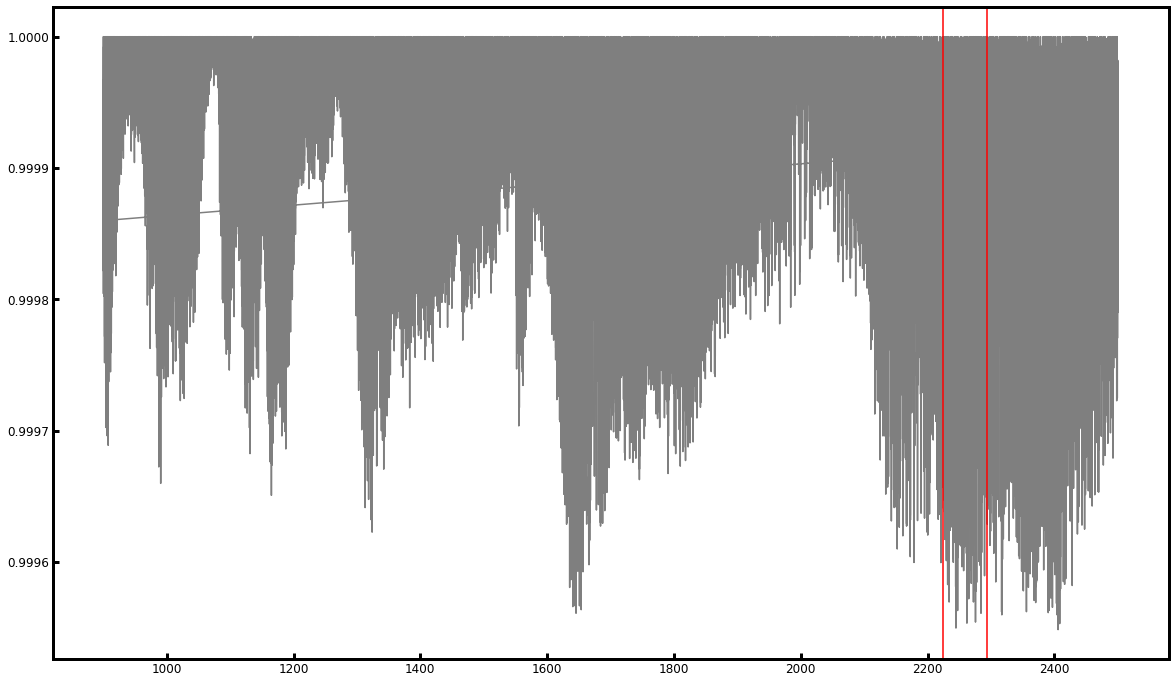

In [35]:
iii = 45
fig = plt.figure(figsize=(20,12))
plt.plot(W_mod,T_depth,'k',alpha=0.5)
plt.axvline(wmod_ord[iii].min(),color='red')
plt.axvline(wmod_ord[iii].max(),color='red')

### ACF of planet model

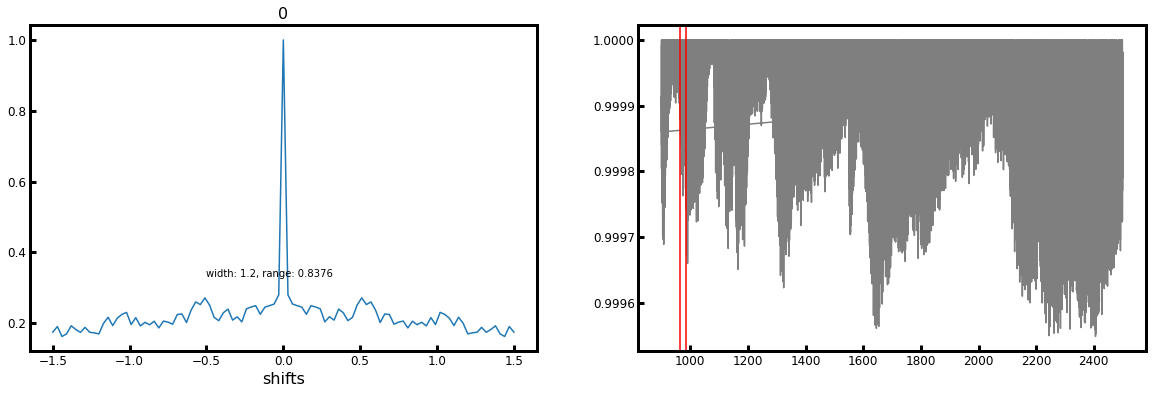

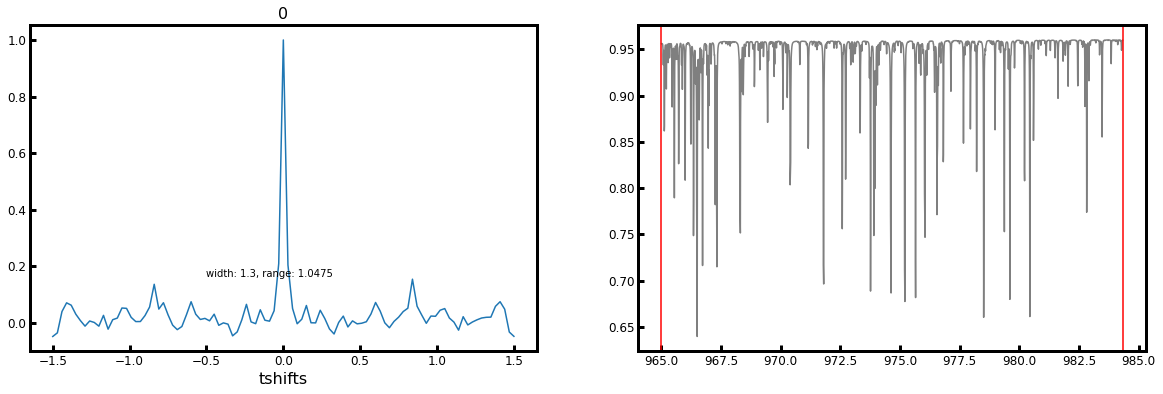

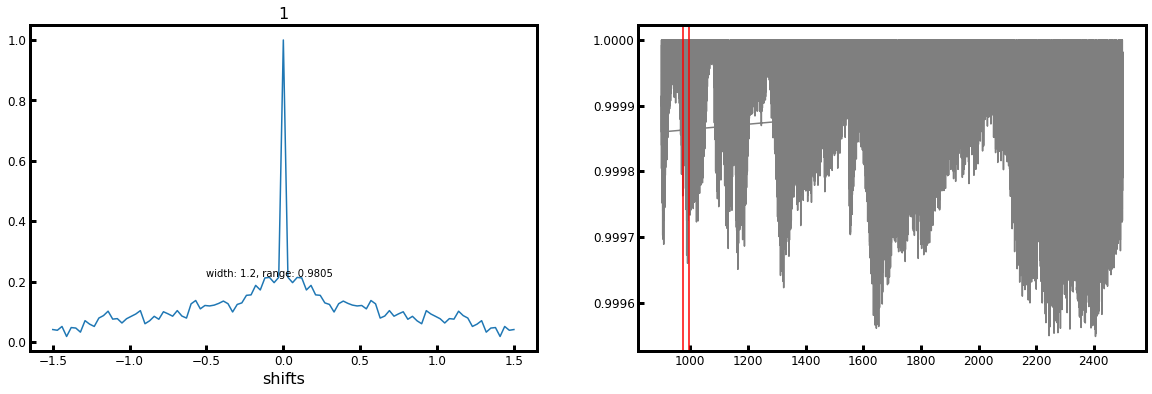

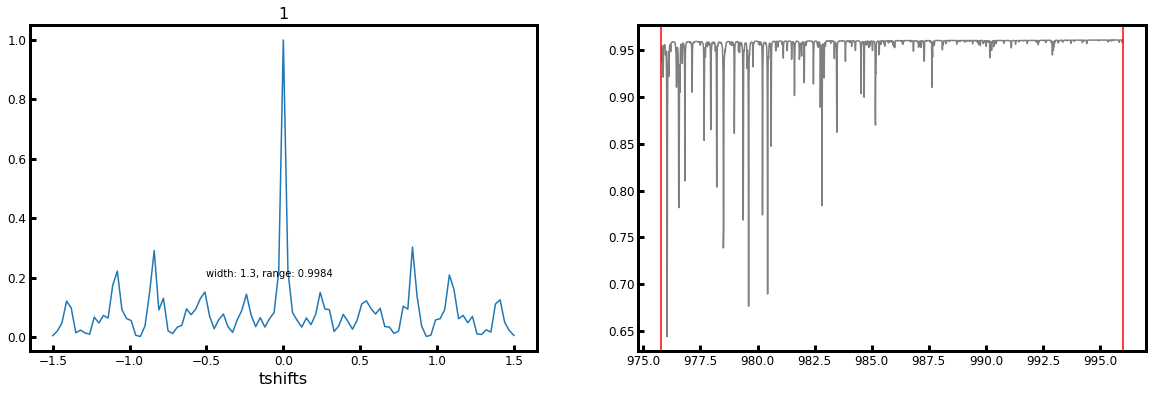

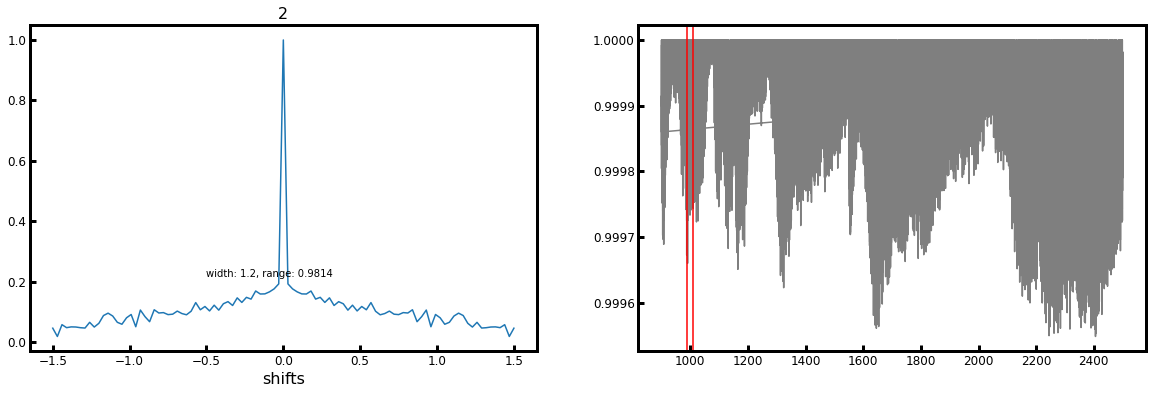

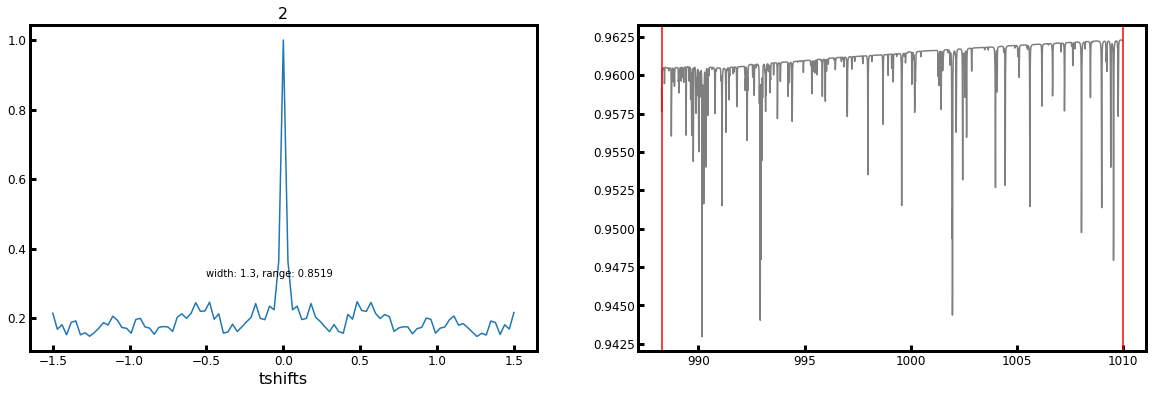

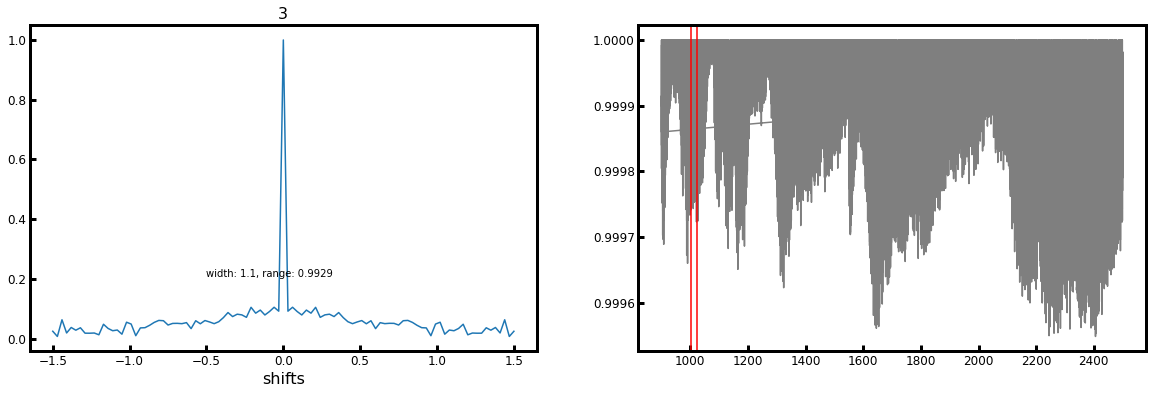

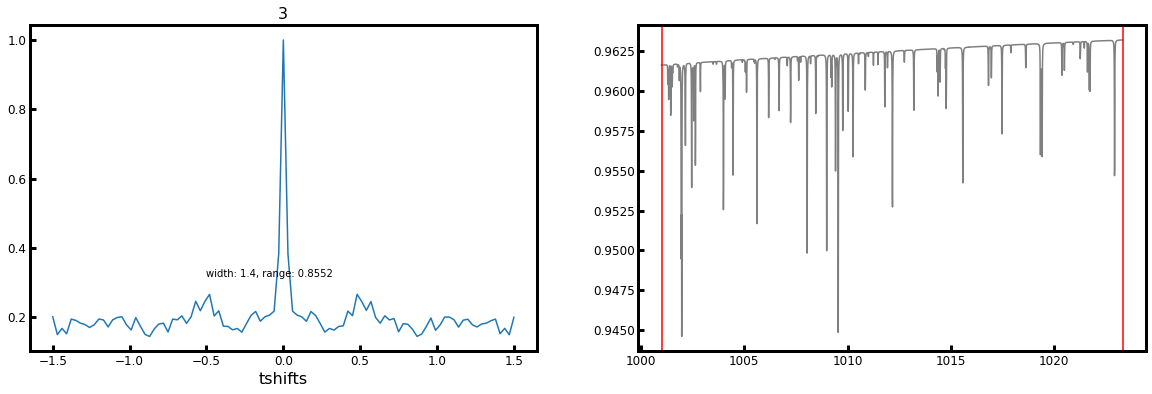

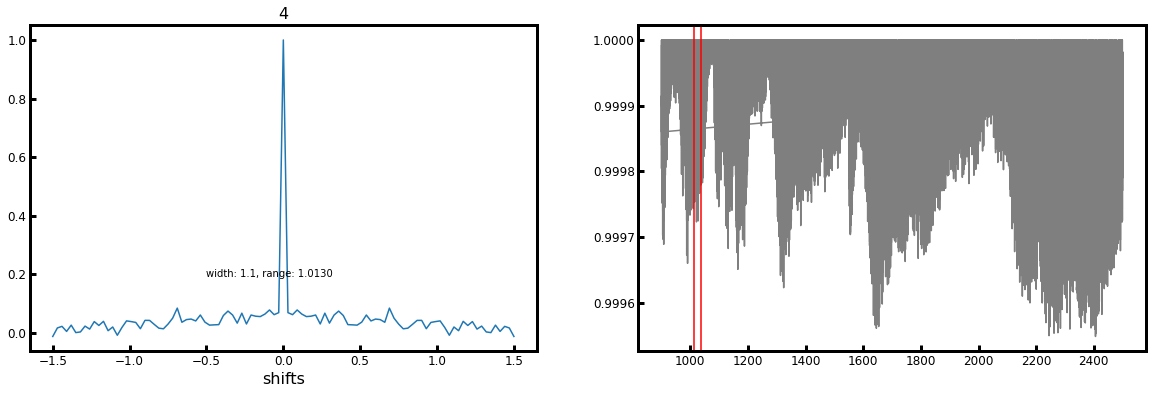

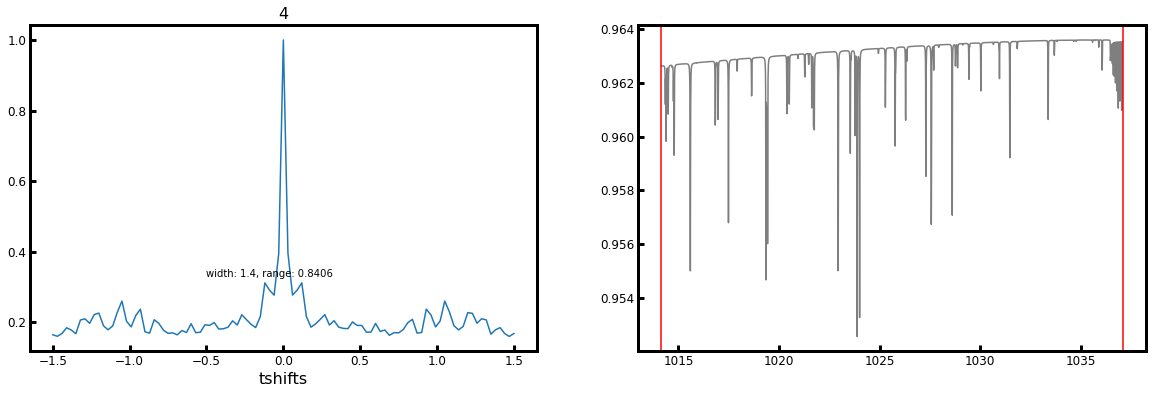

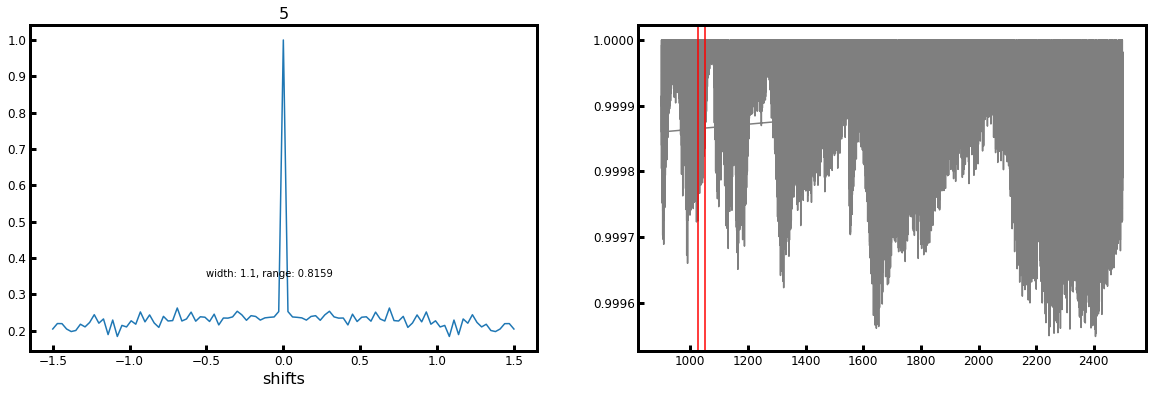

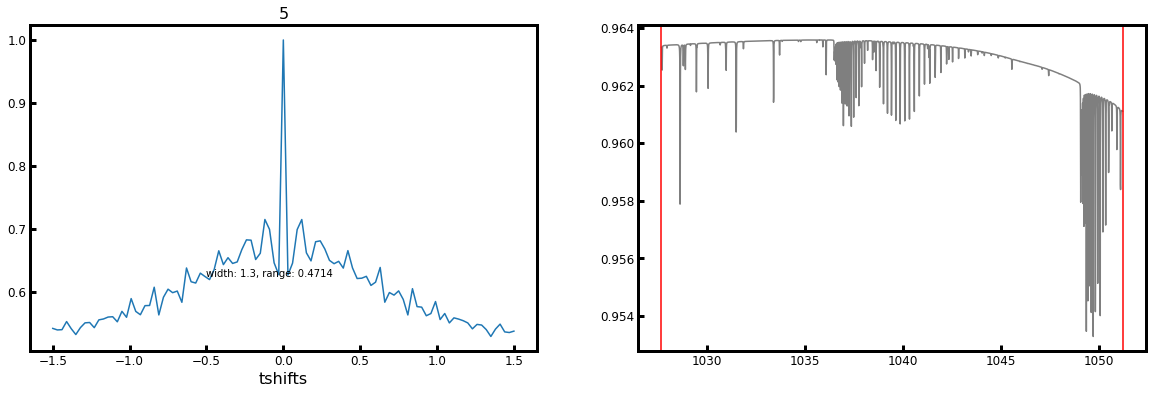

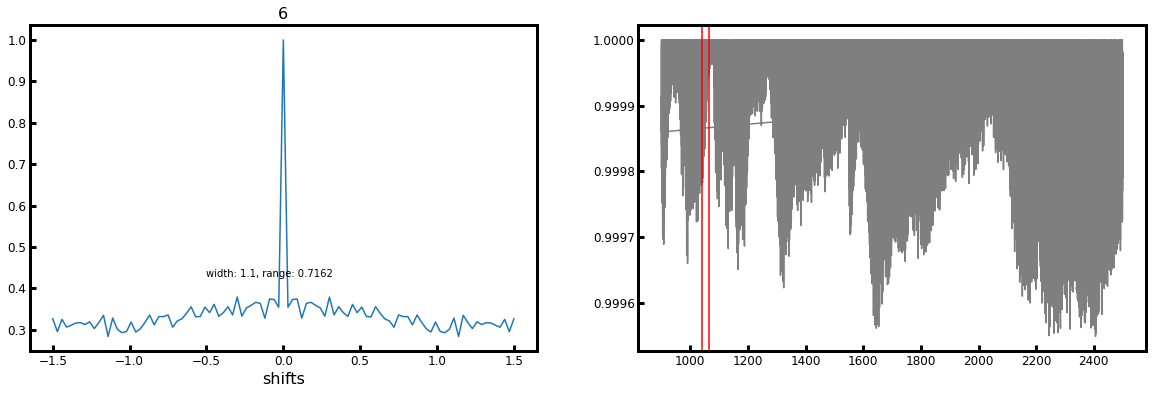

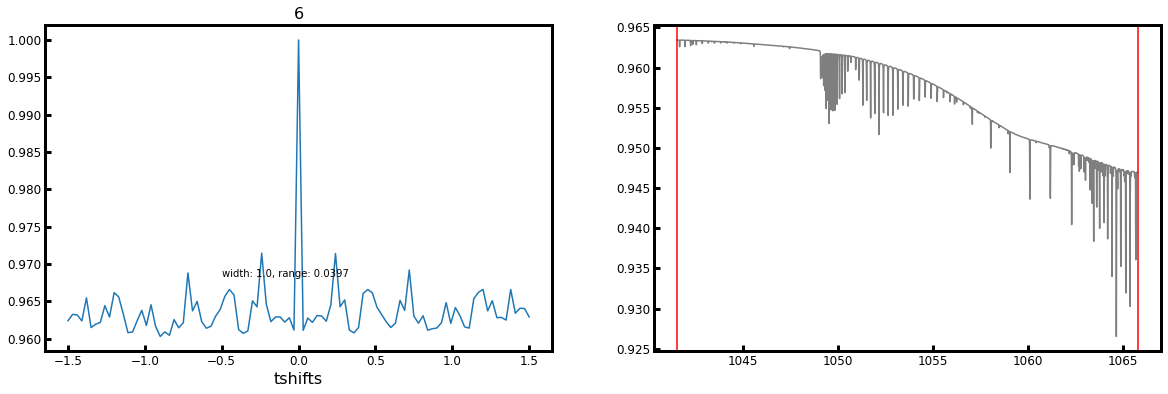

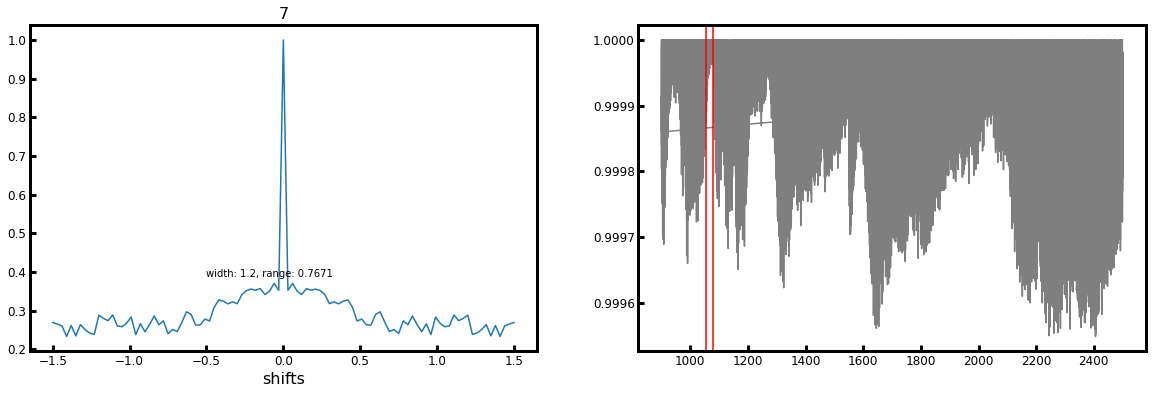

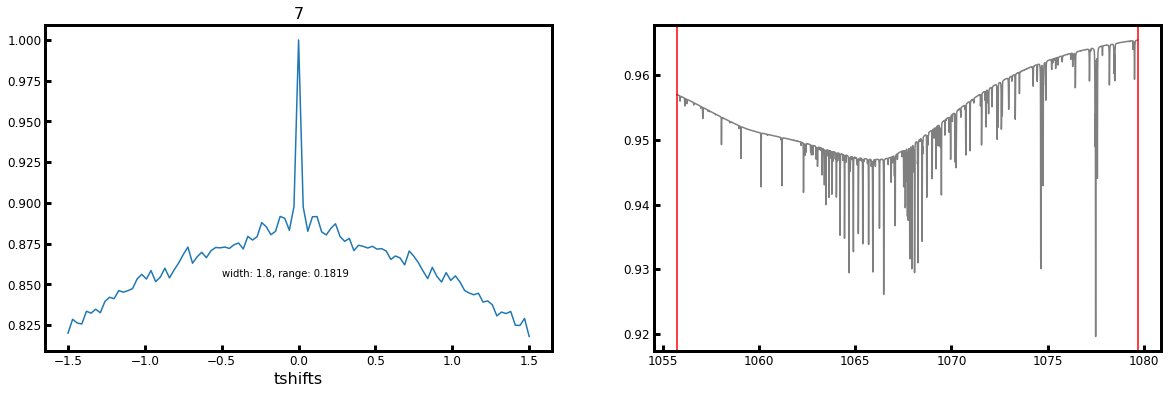

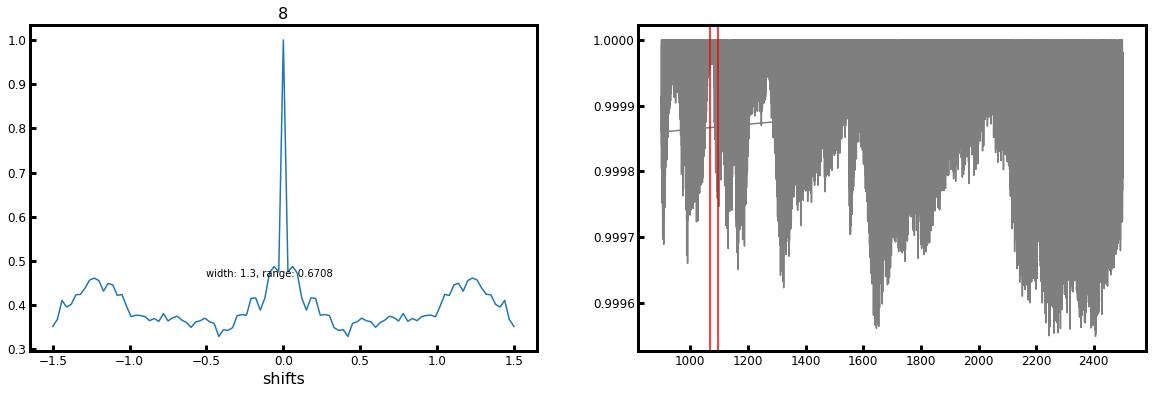

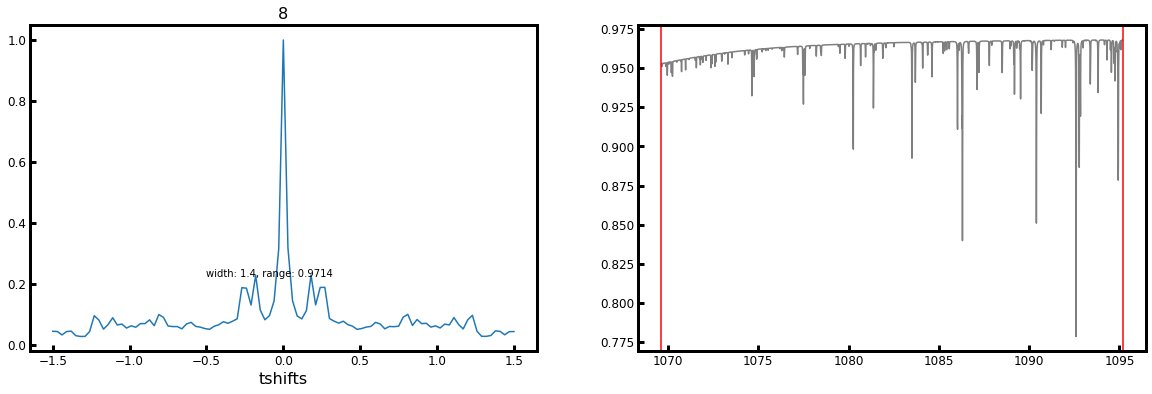

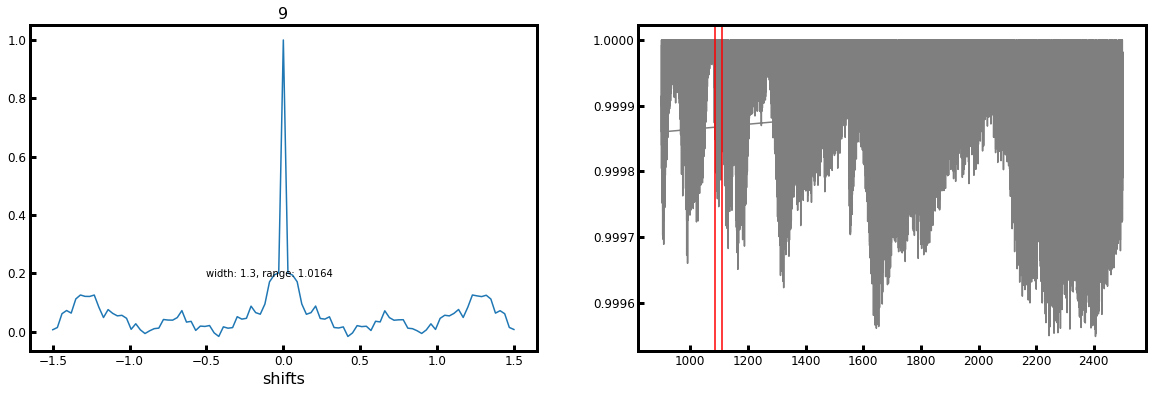

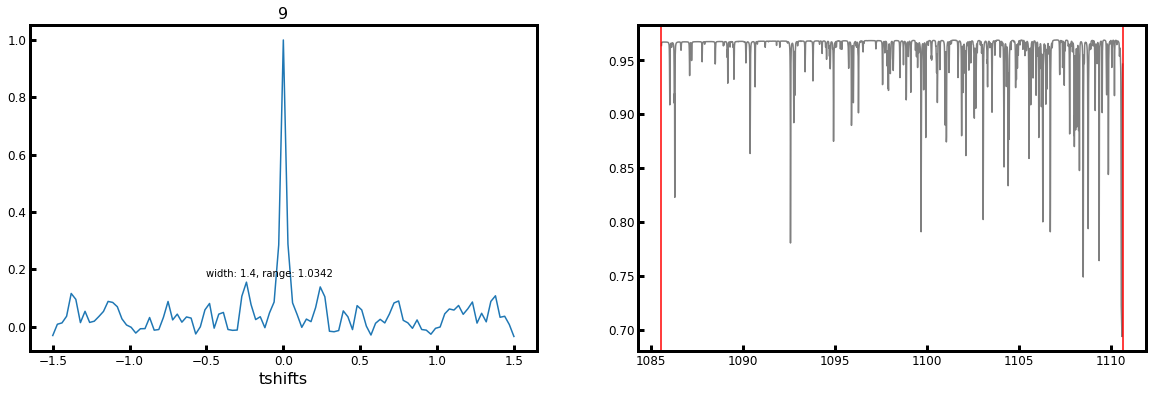

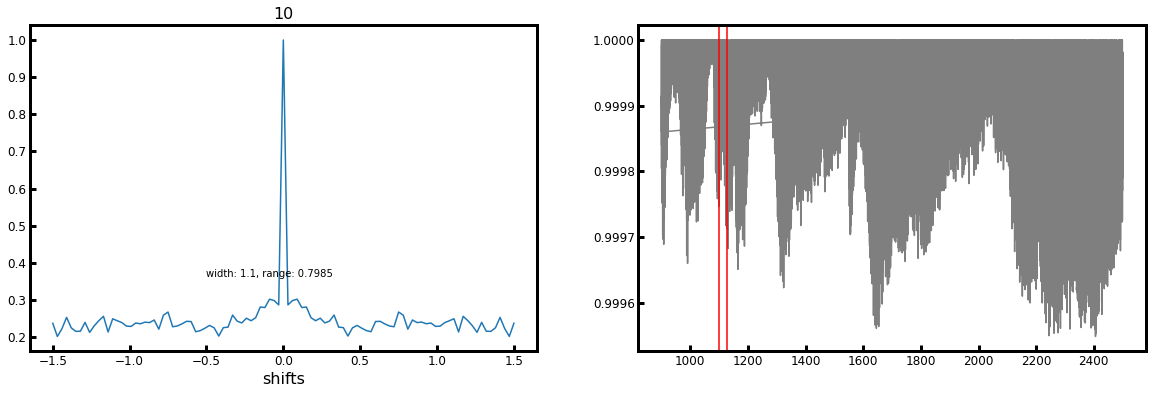

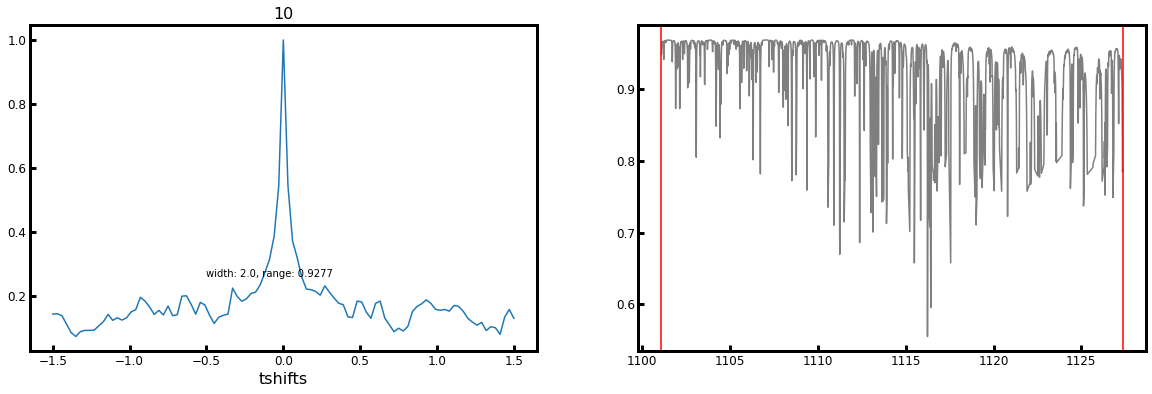

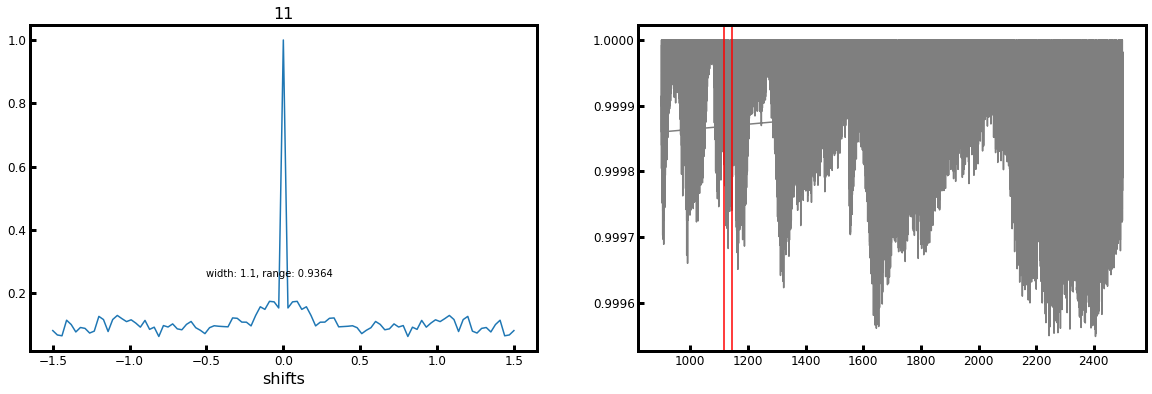

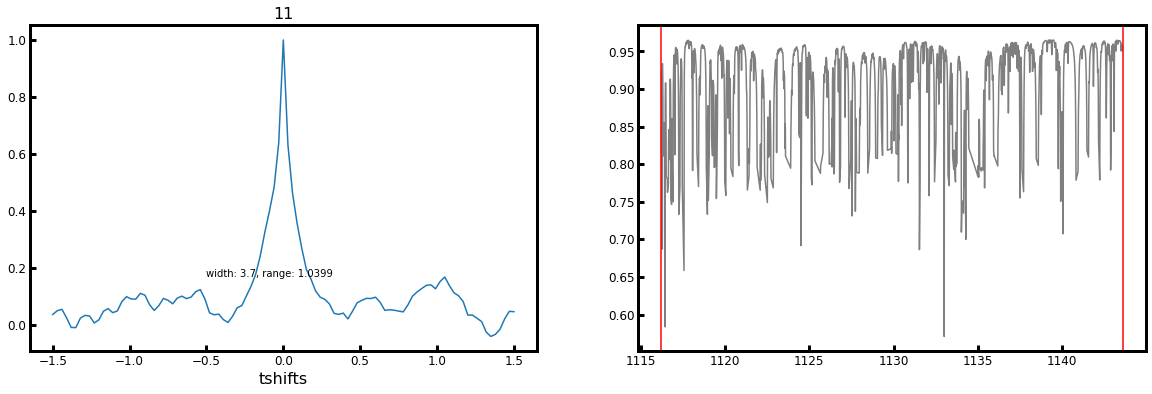

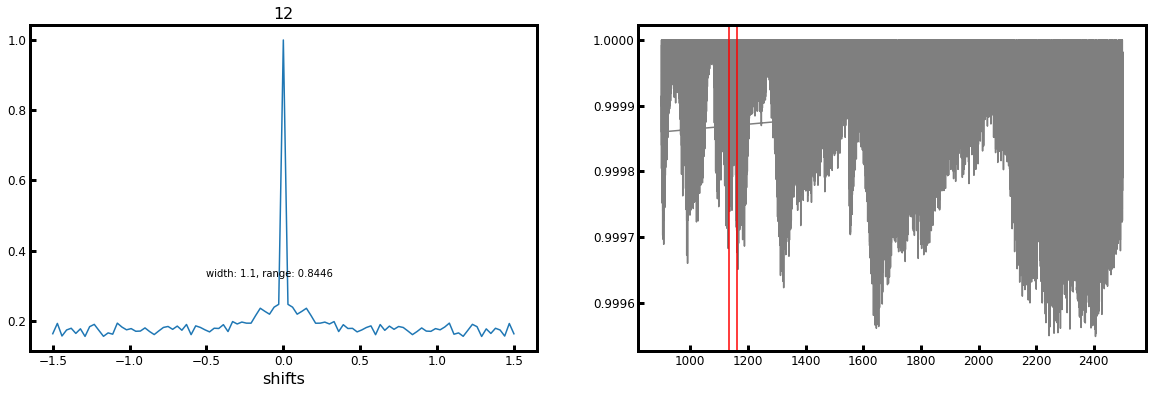

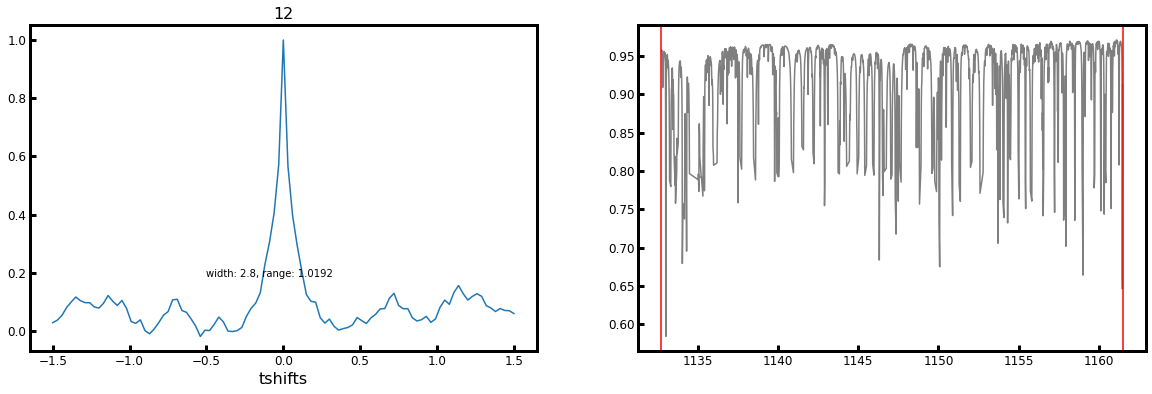

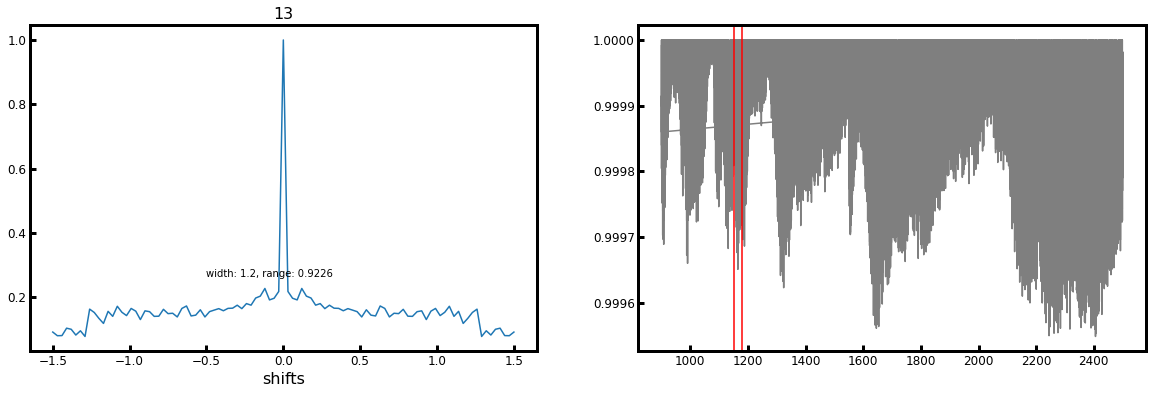

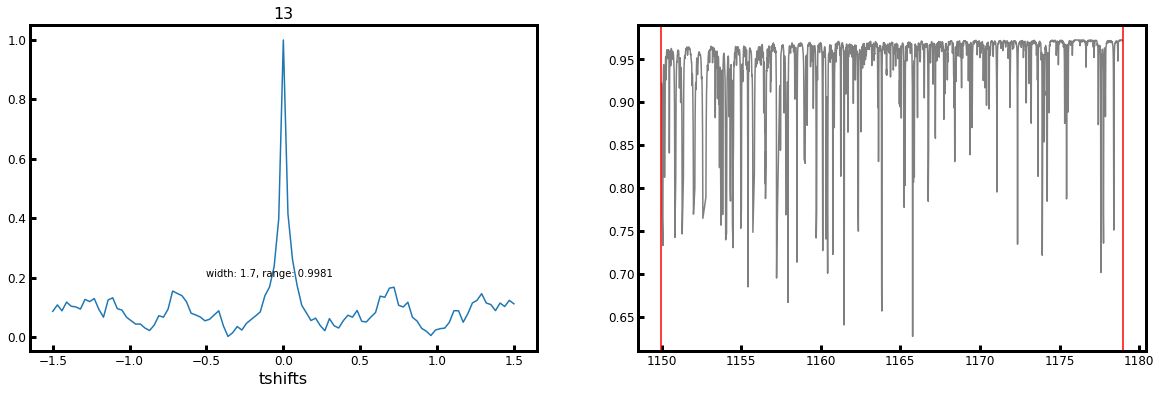

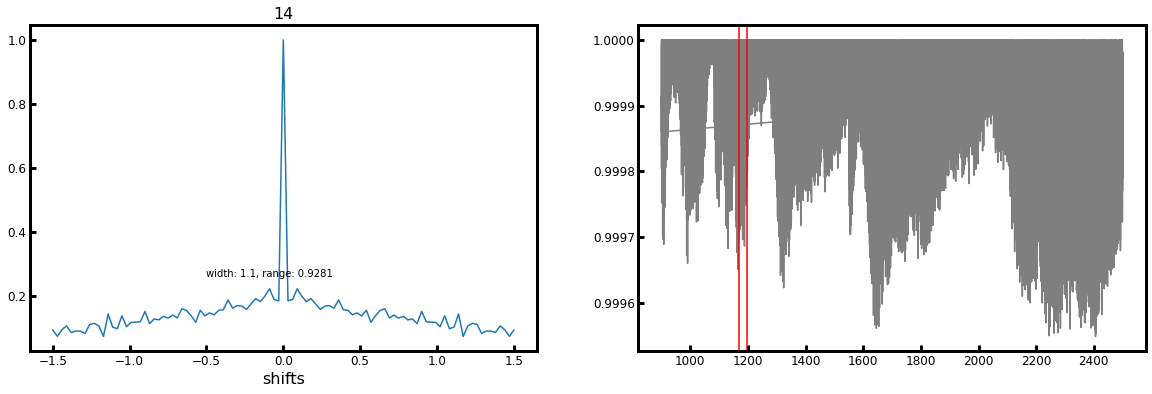

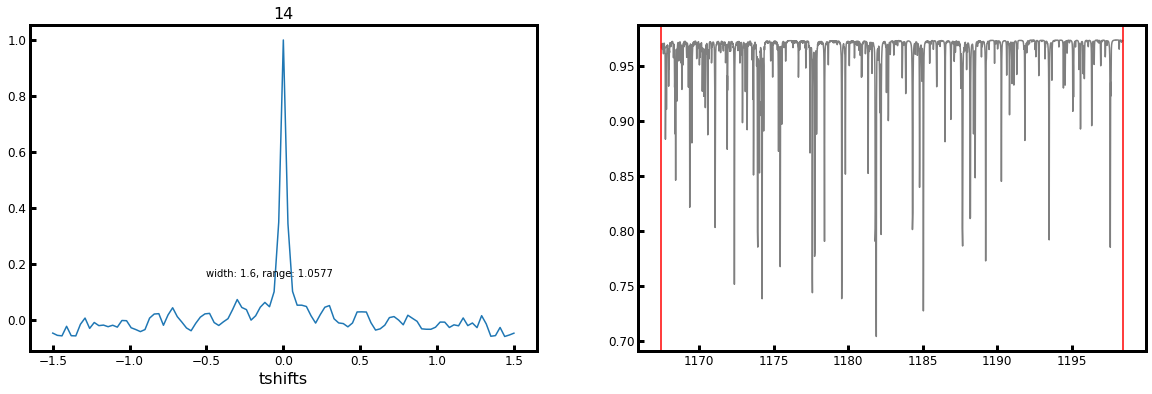

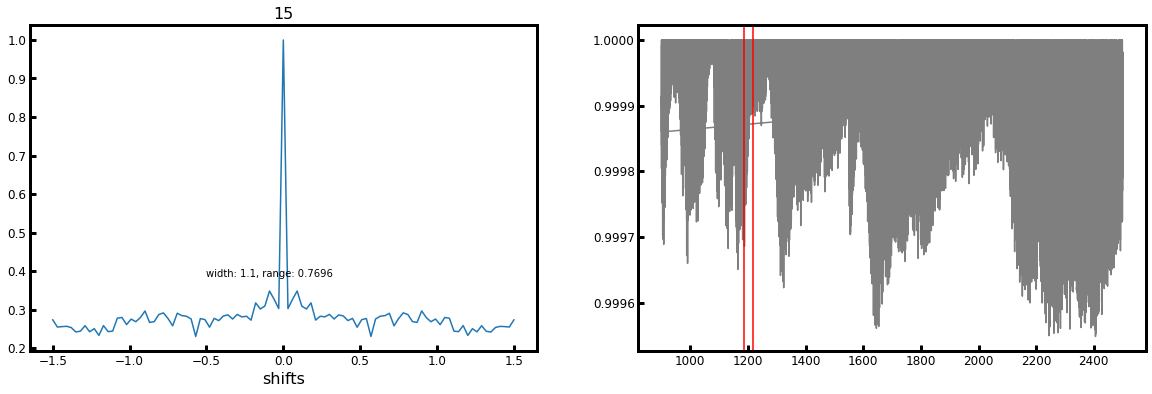

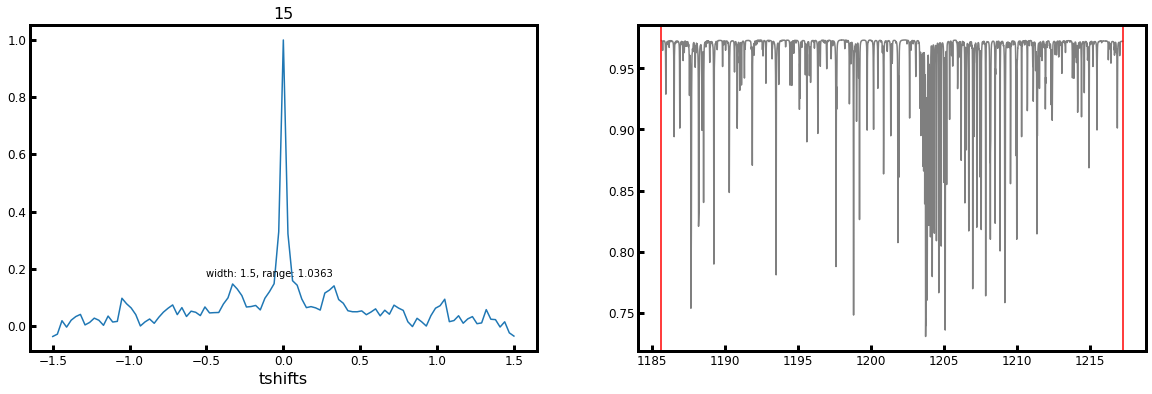

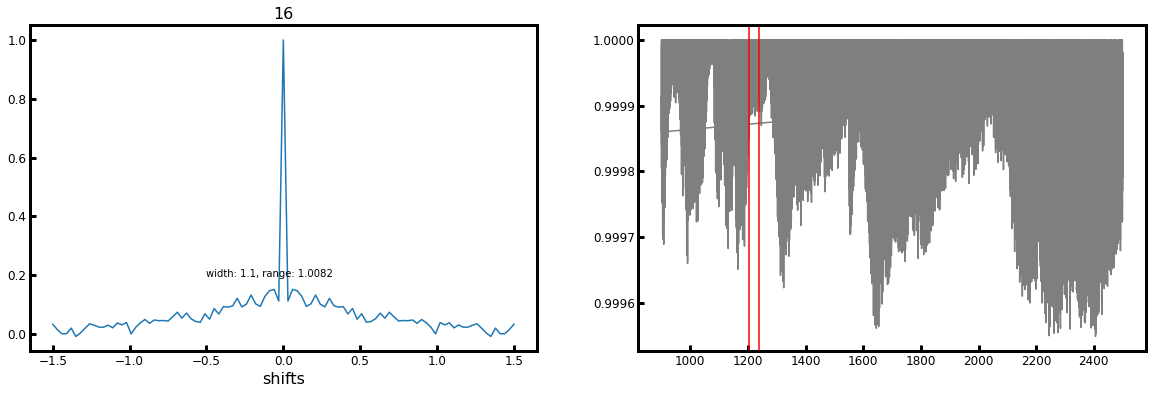

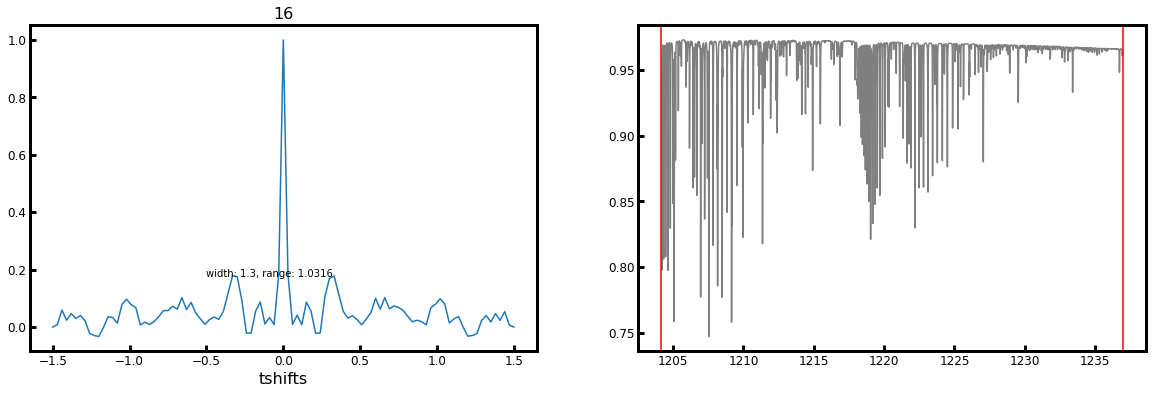

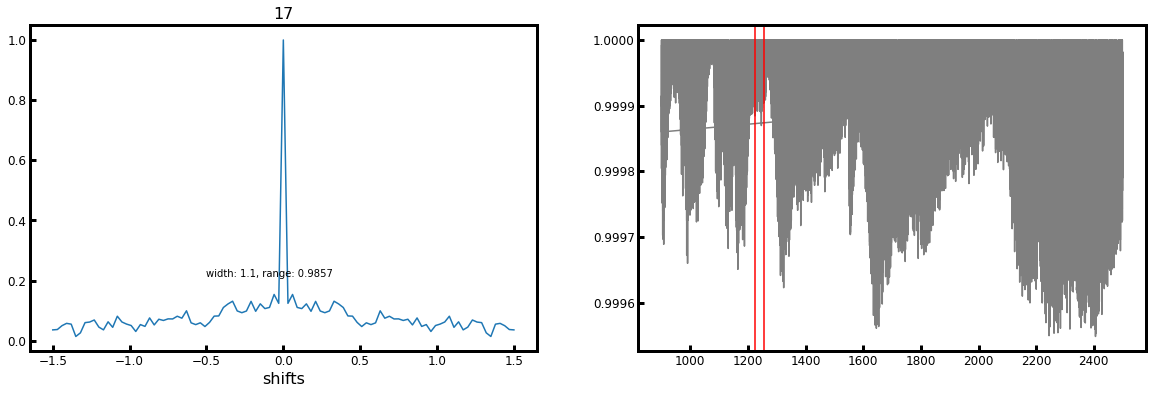

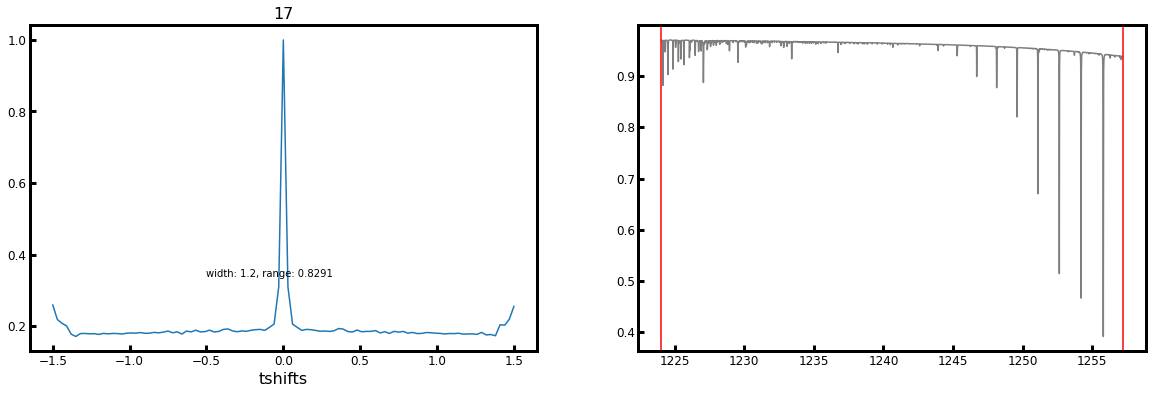

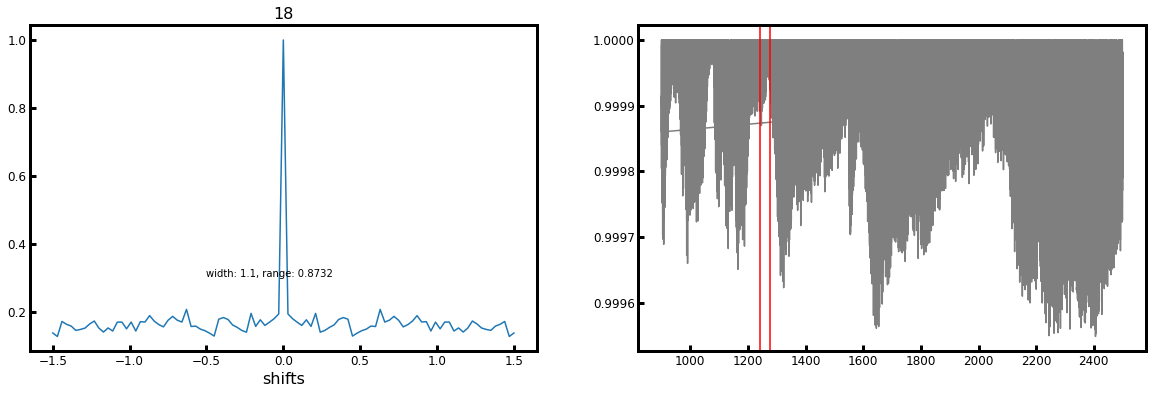

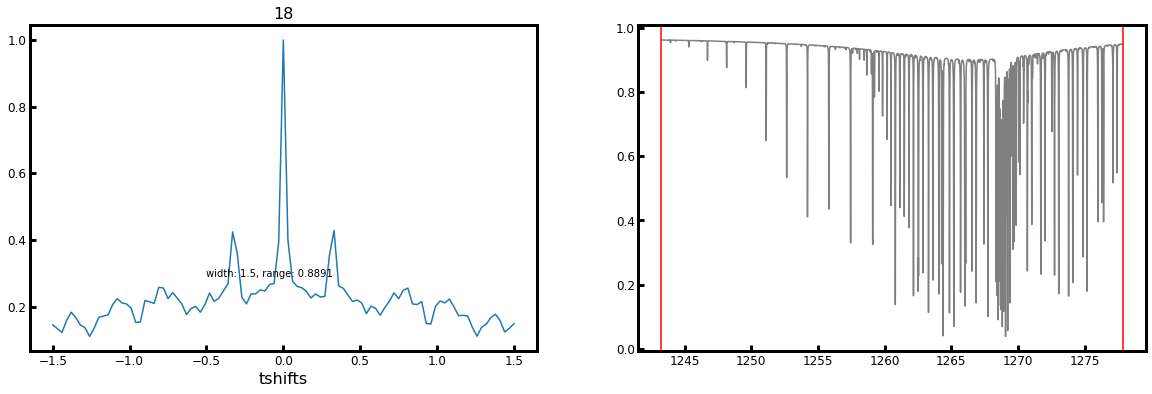

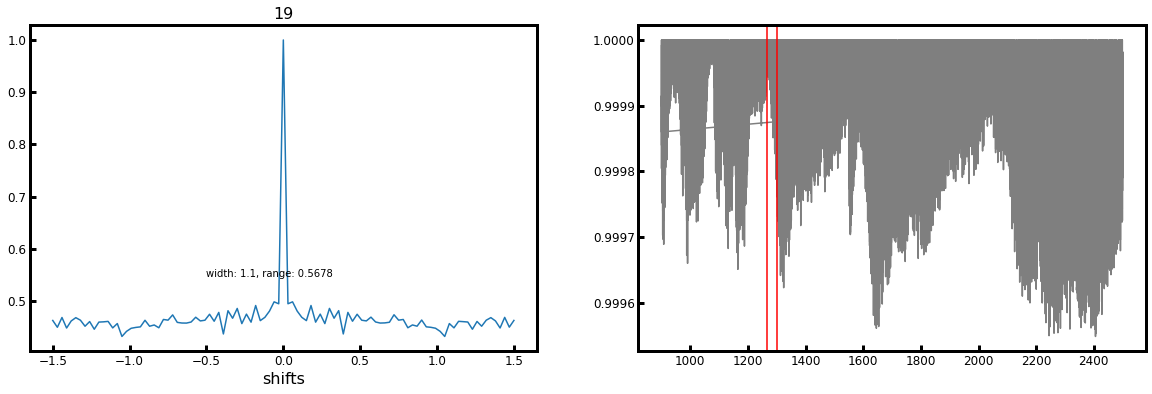

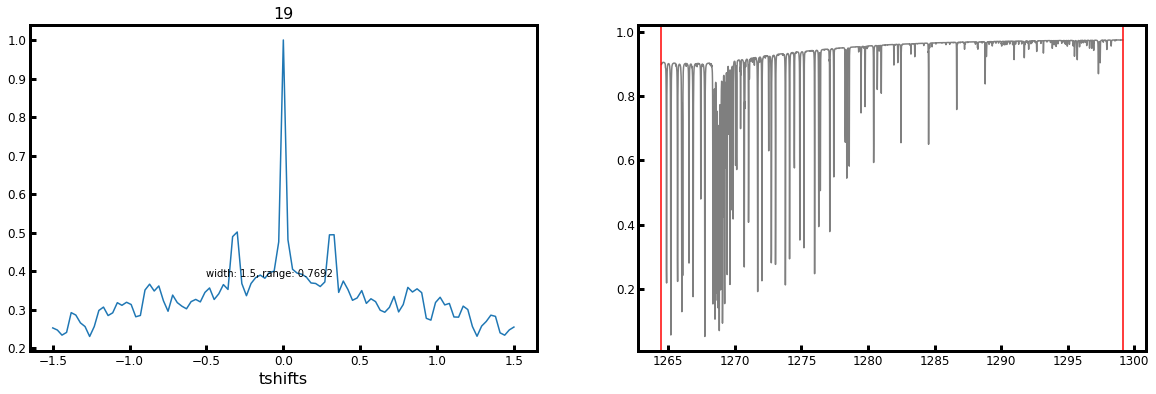

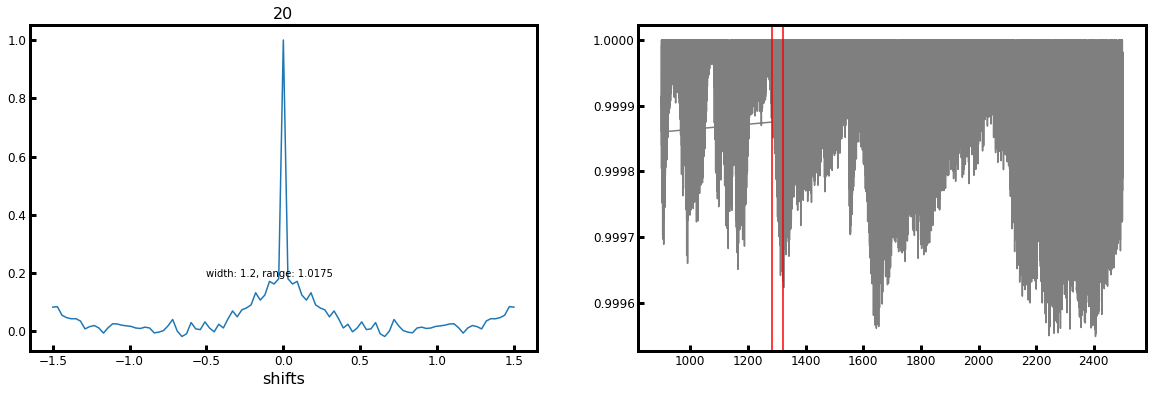

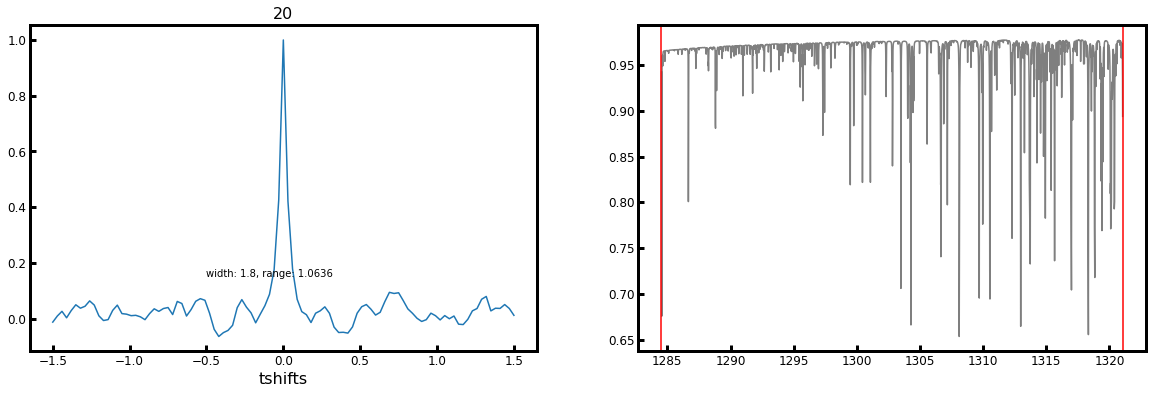

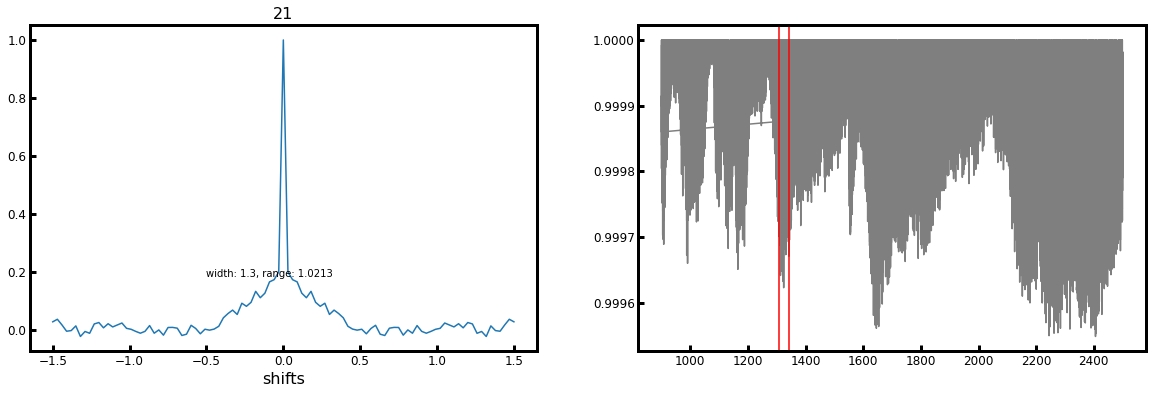

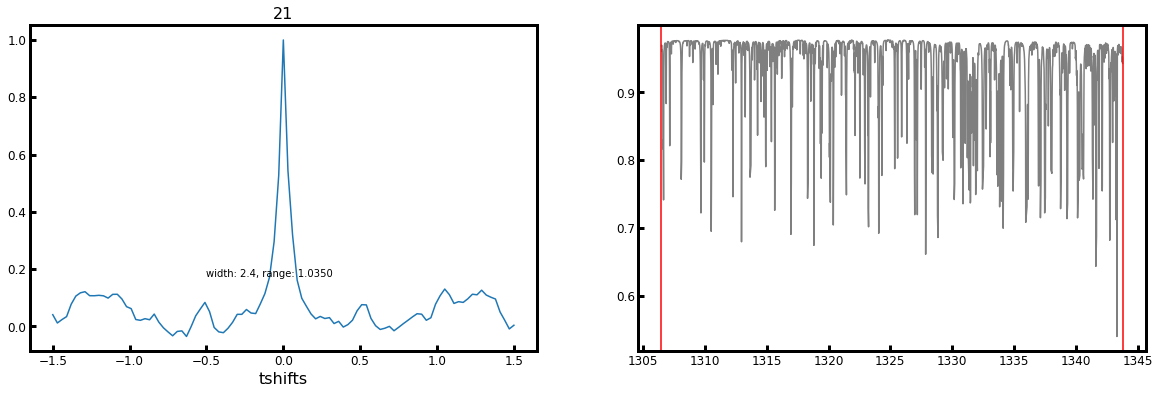

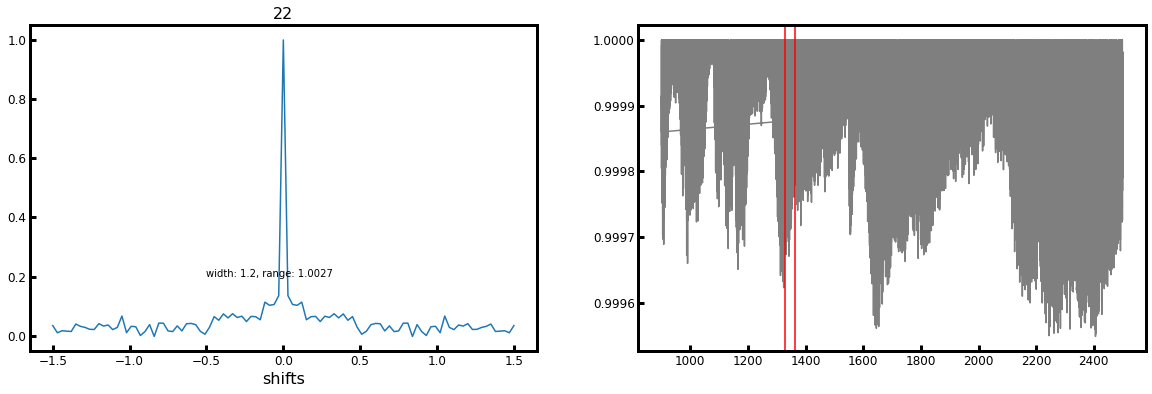

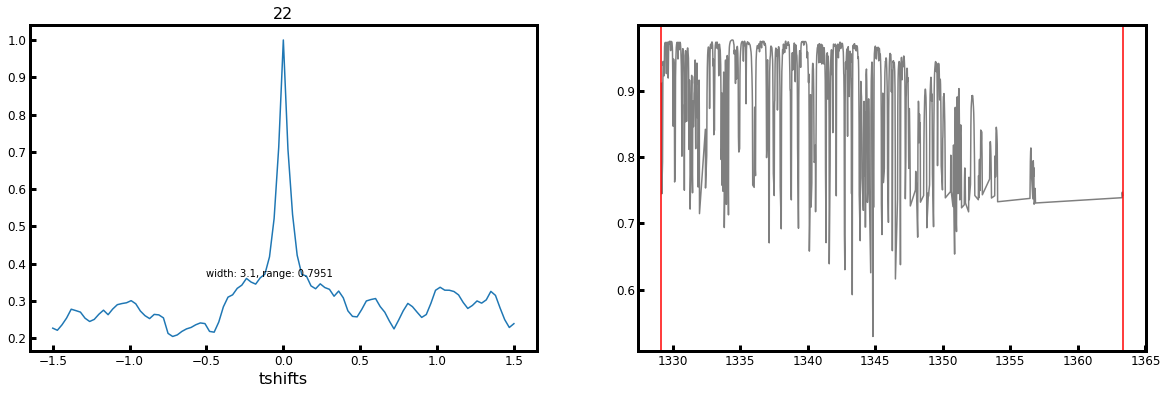

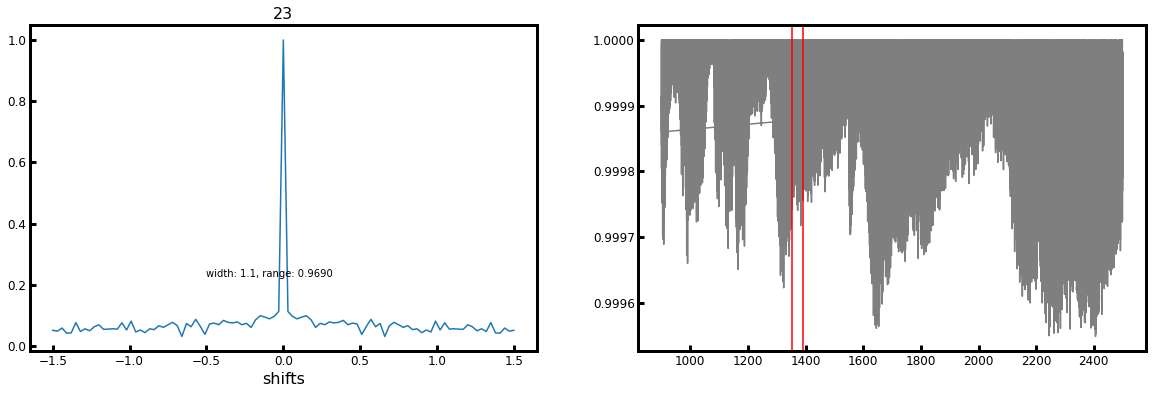

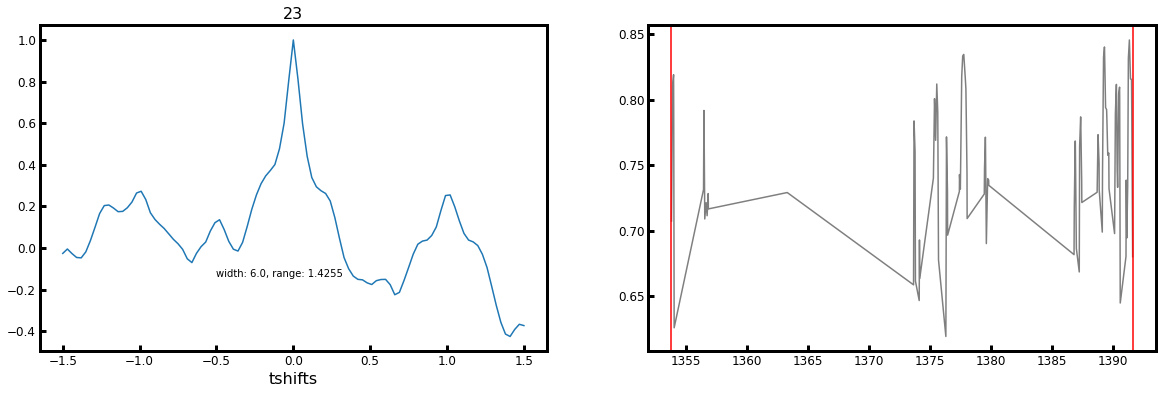

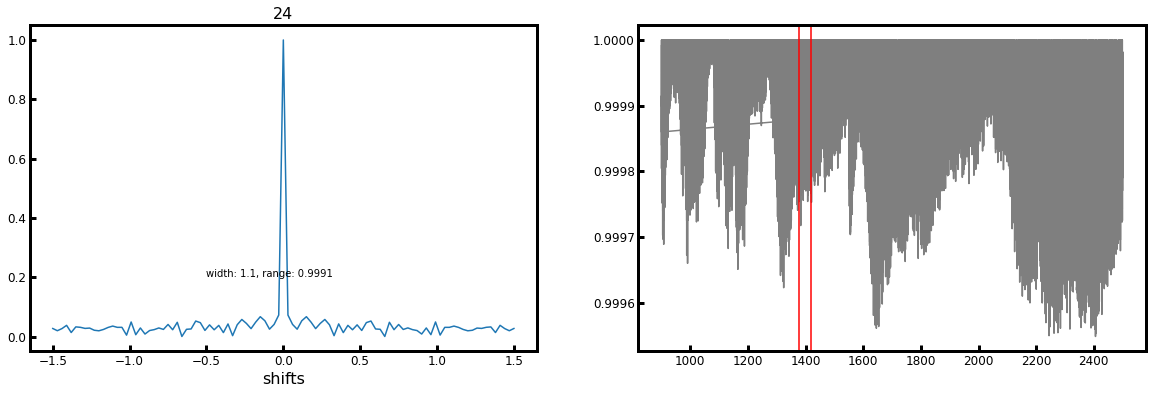

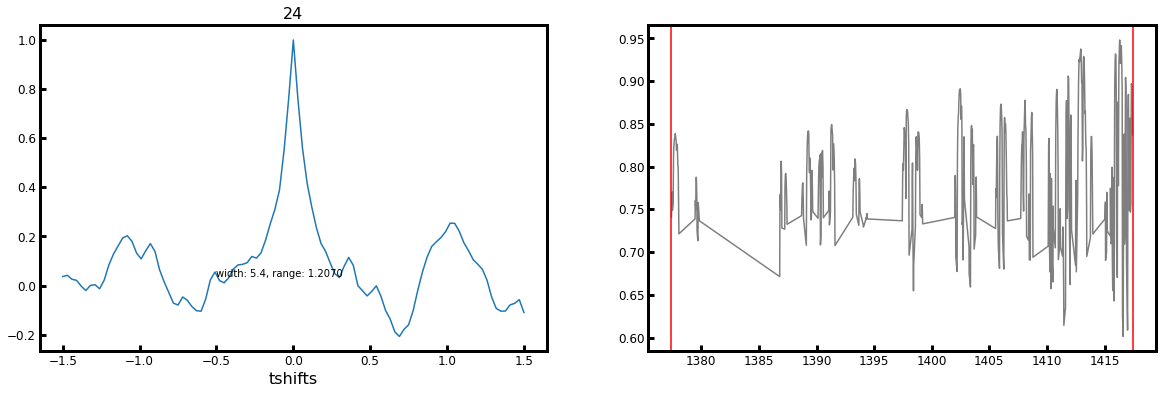

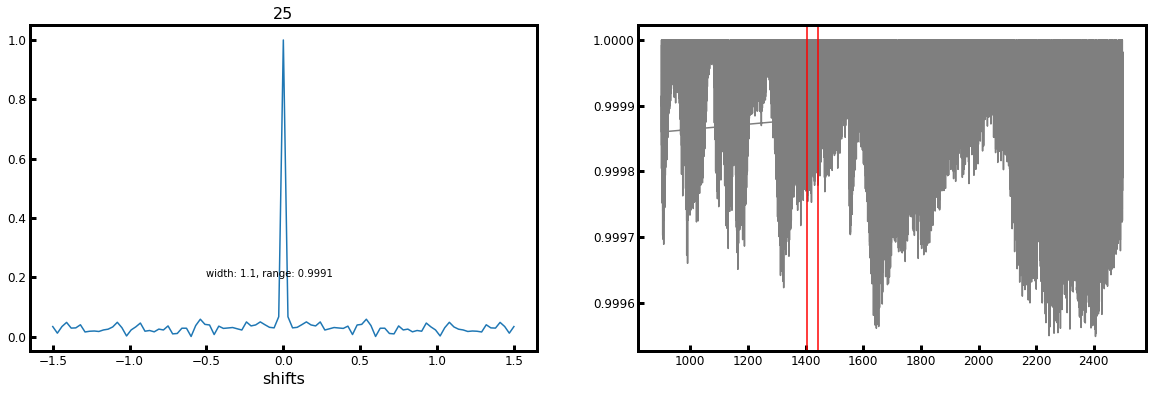

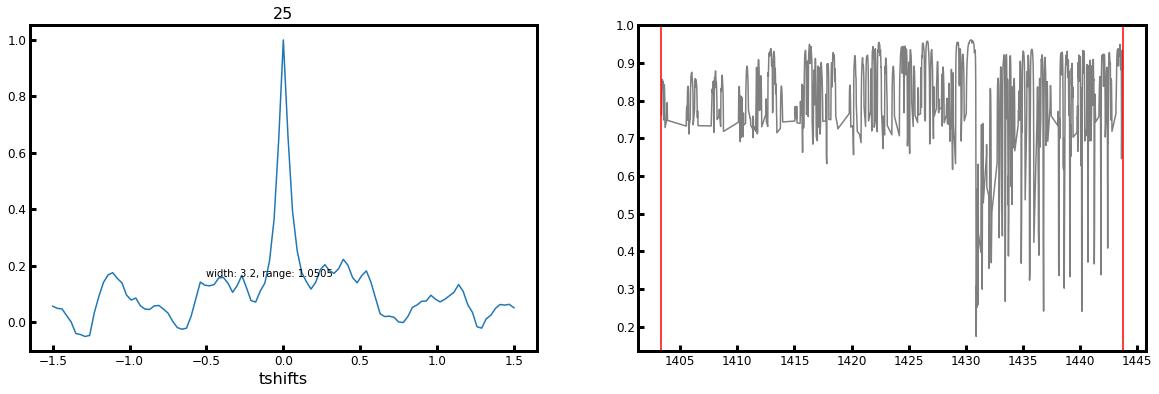

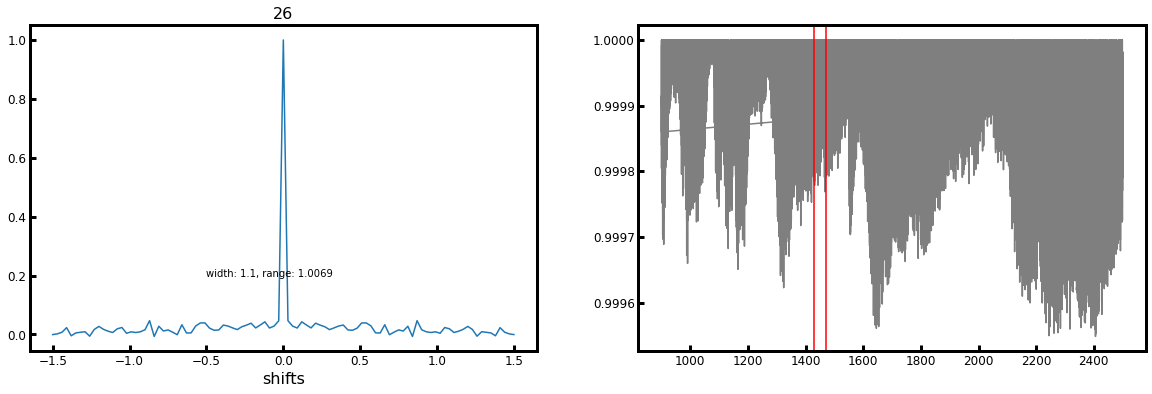

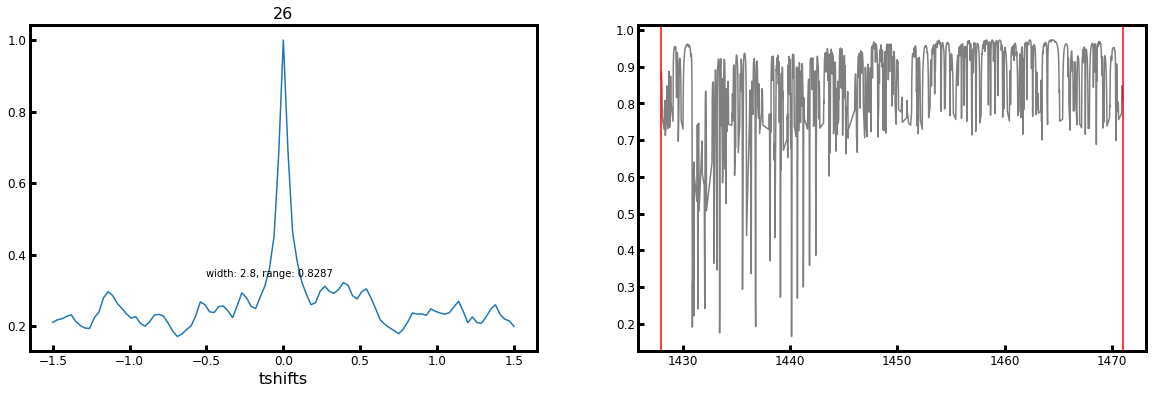

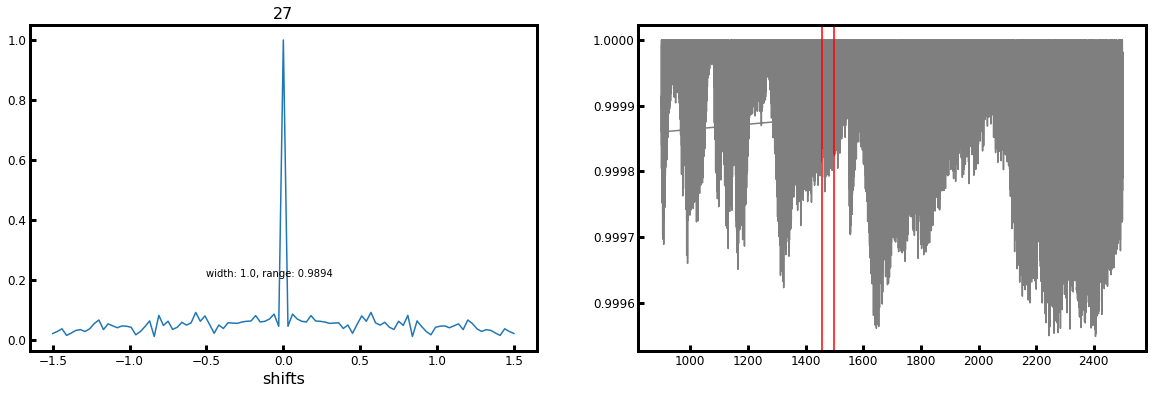

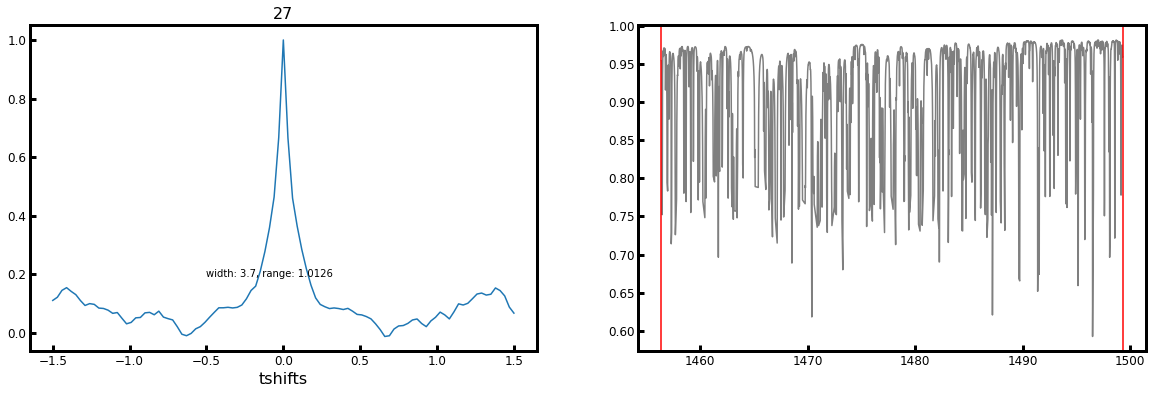

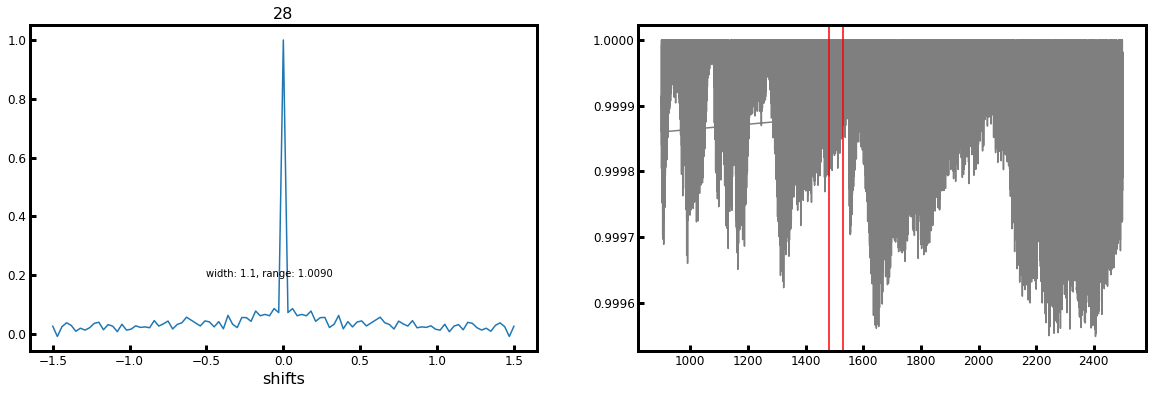

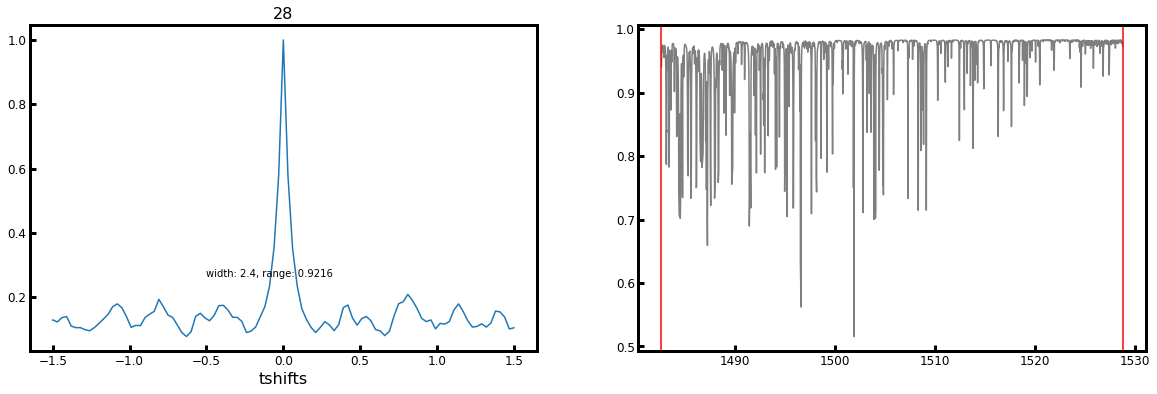

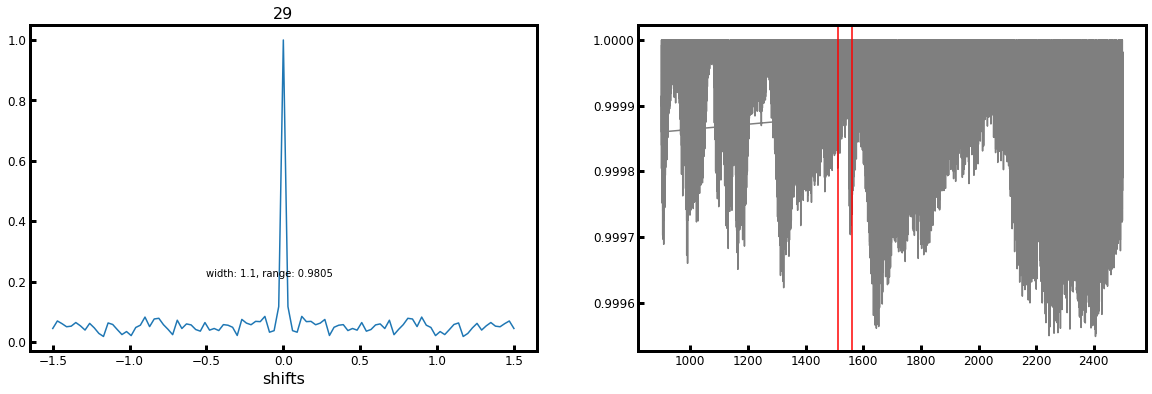

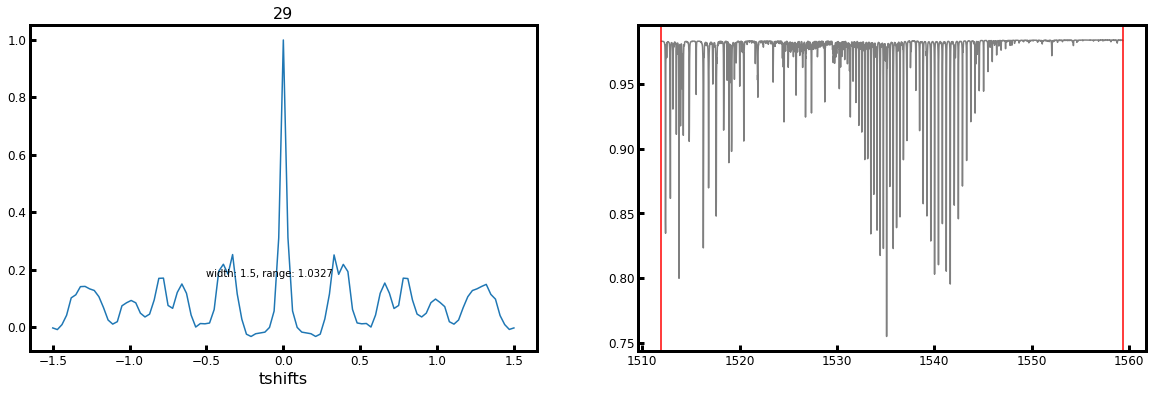

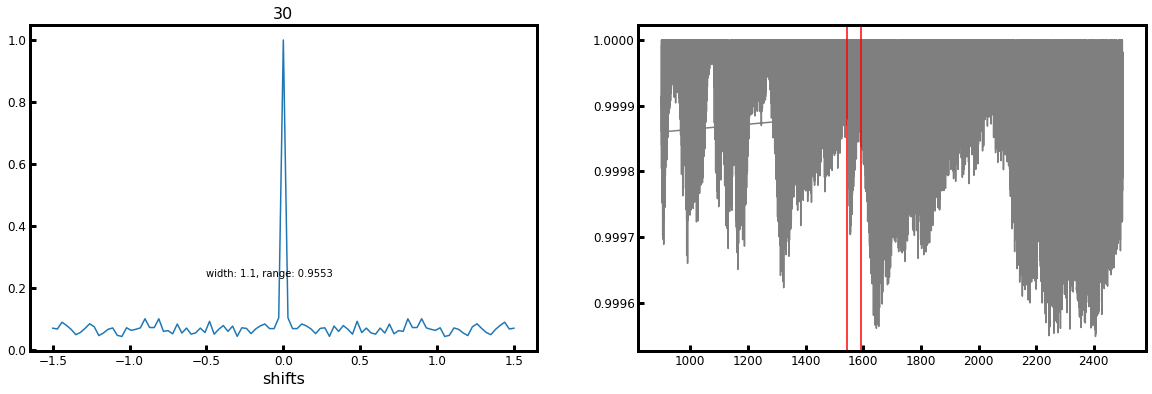

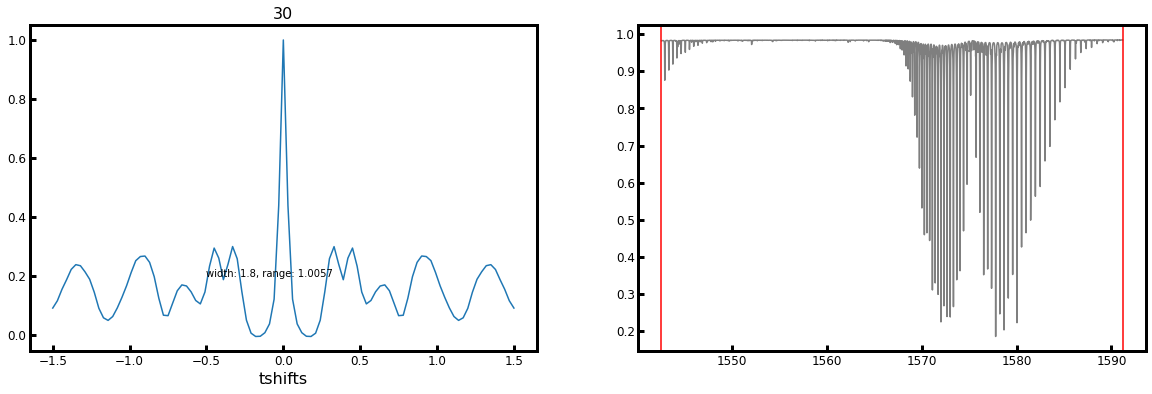

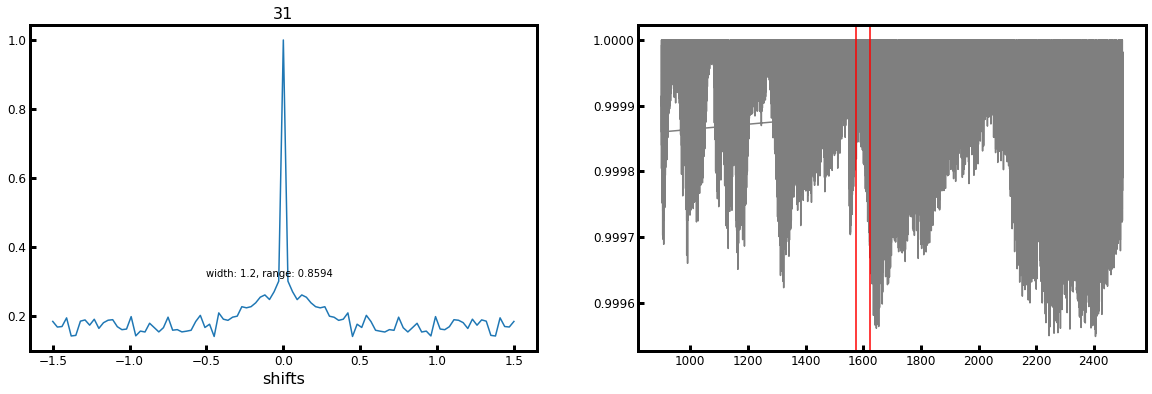

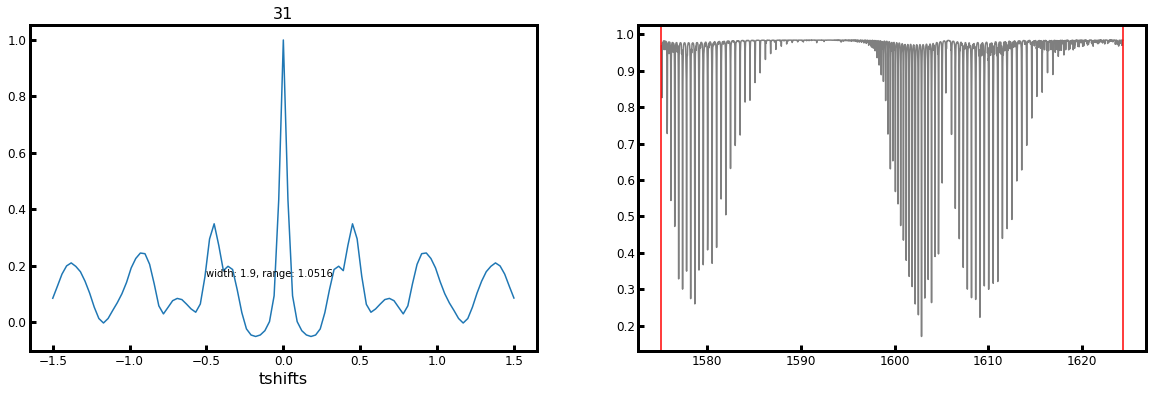

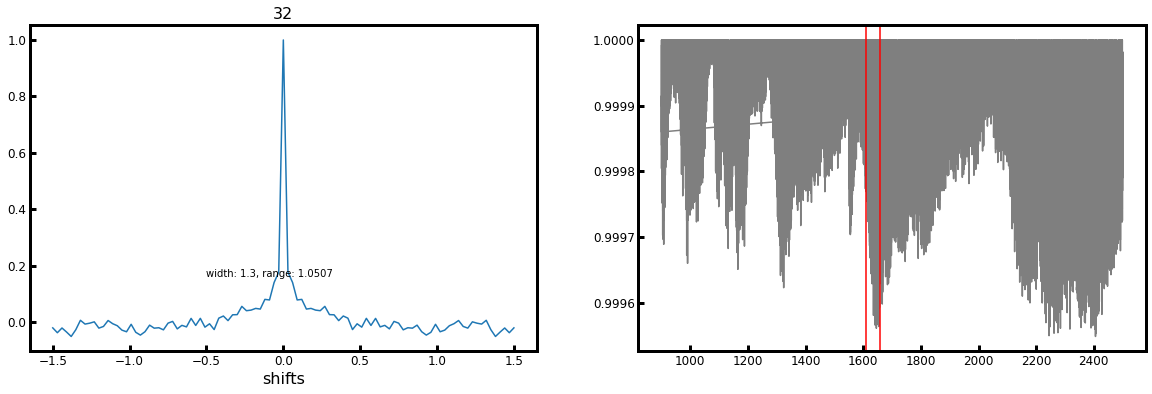

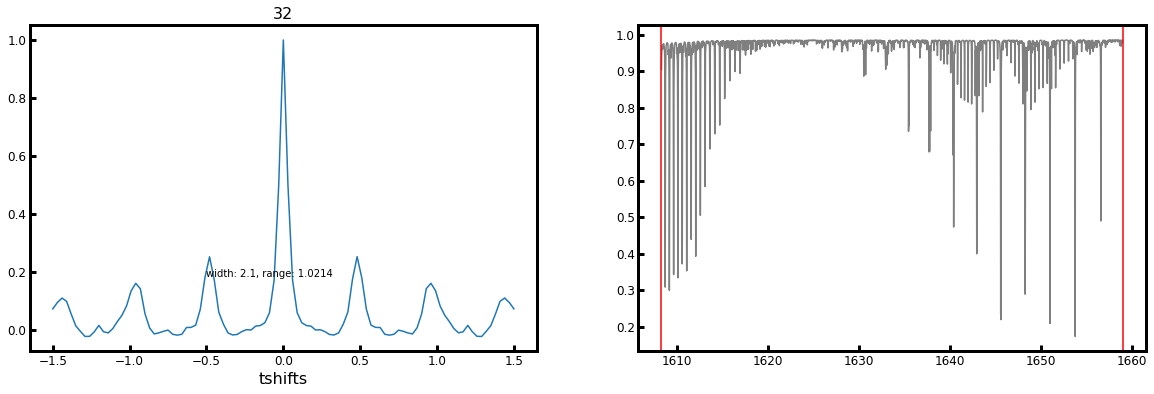

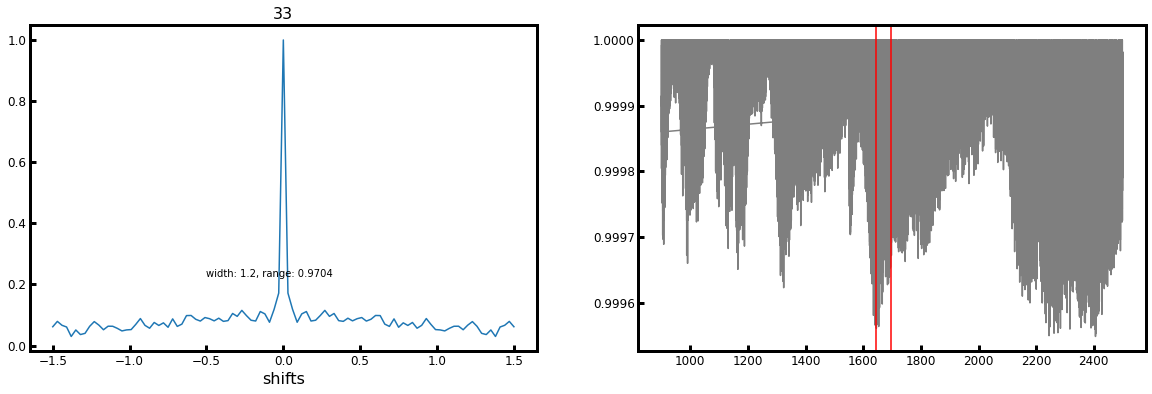

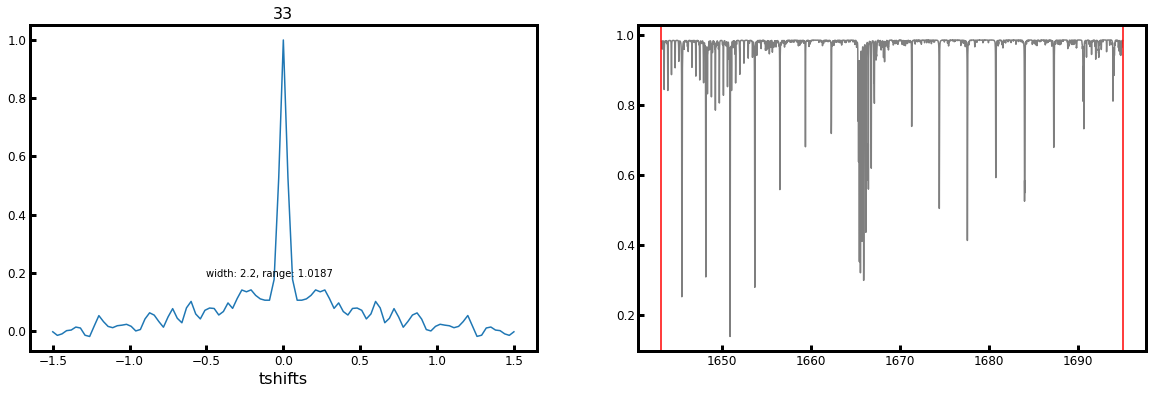

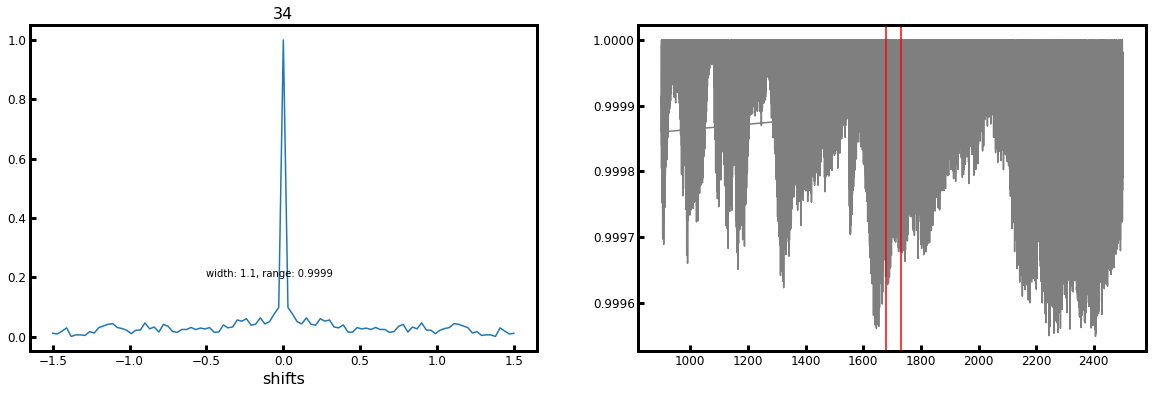

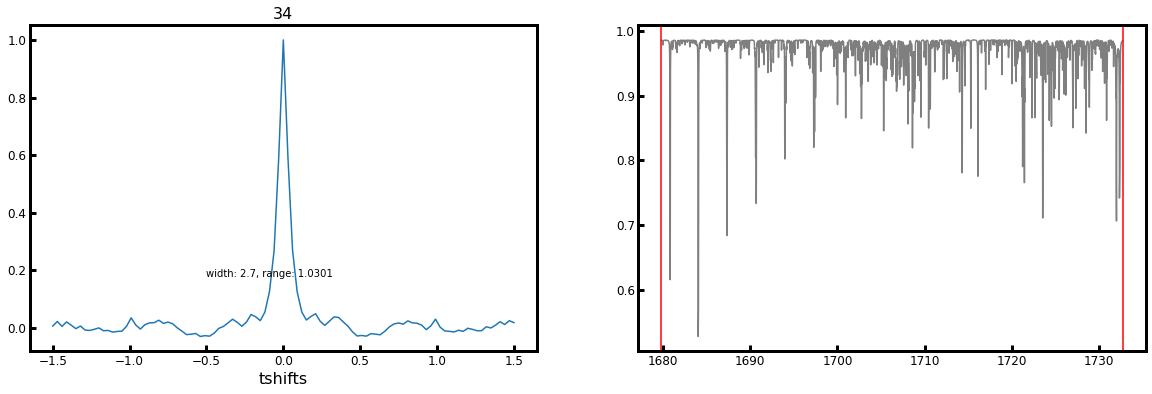

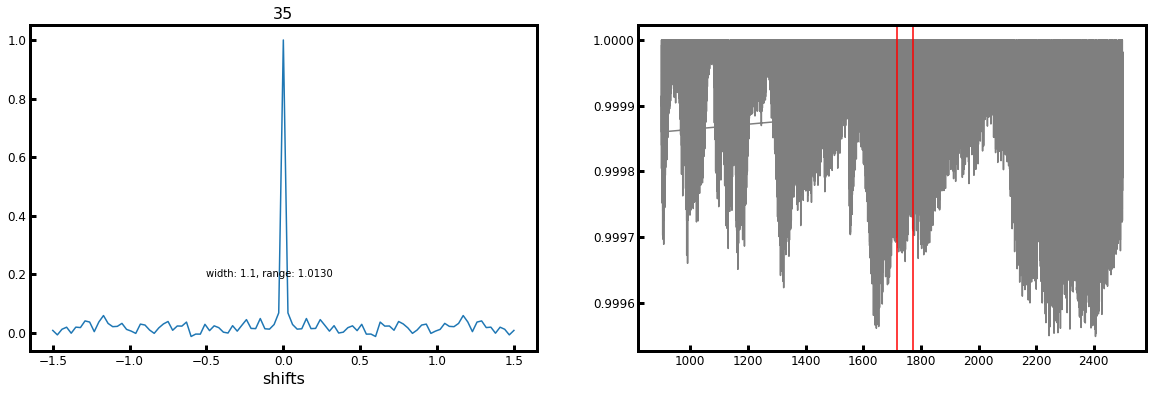

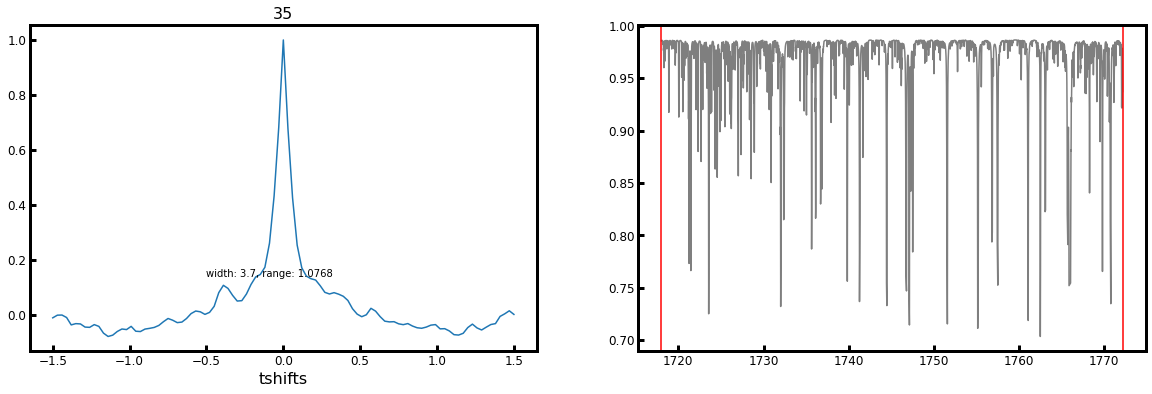

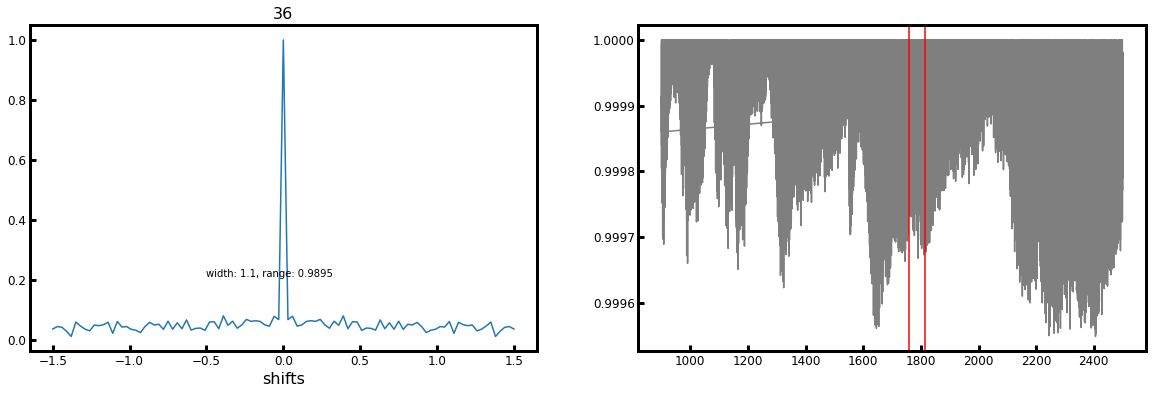

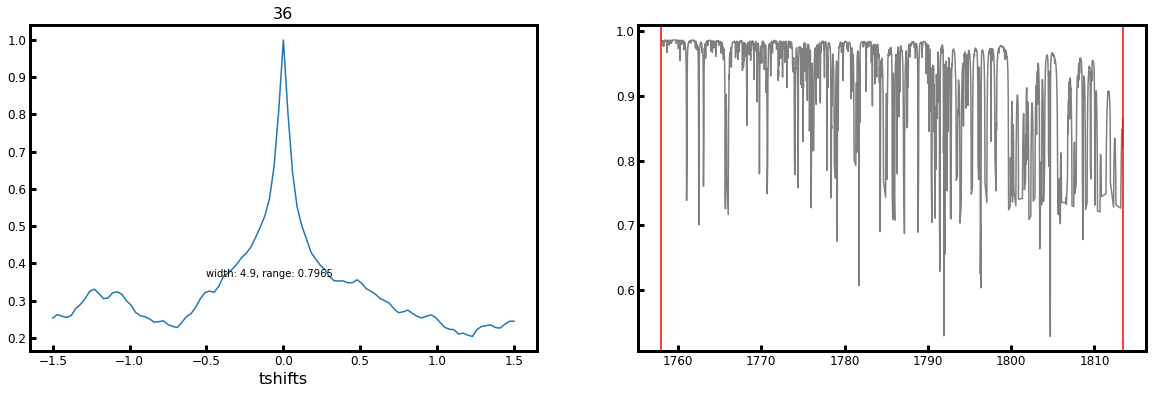

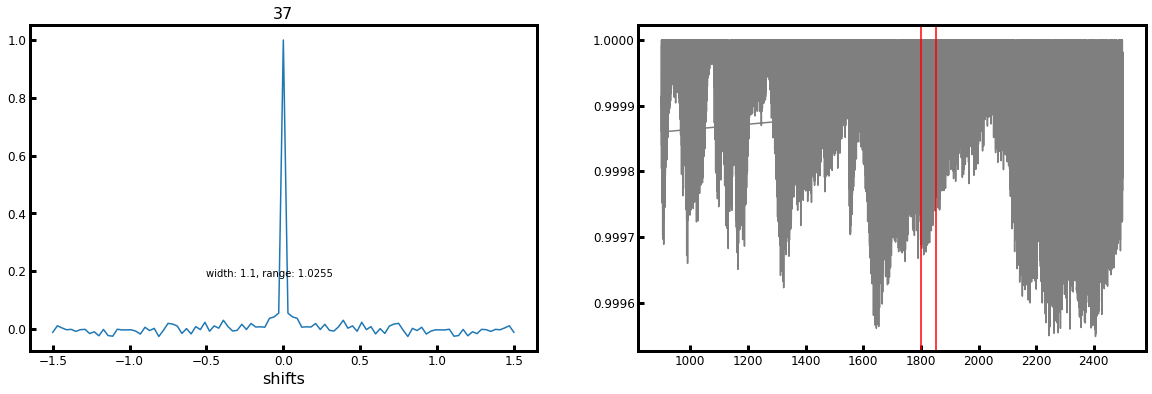

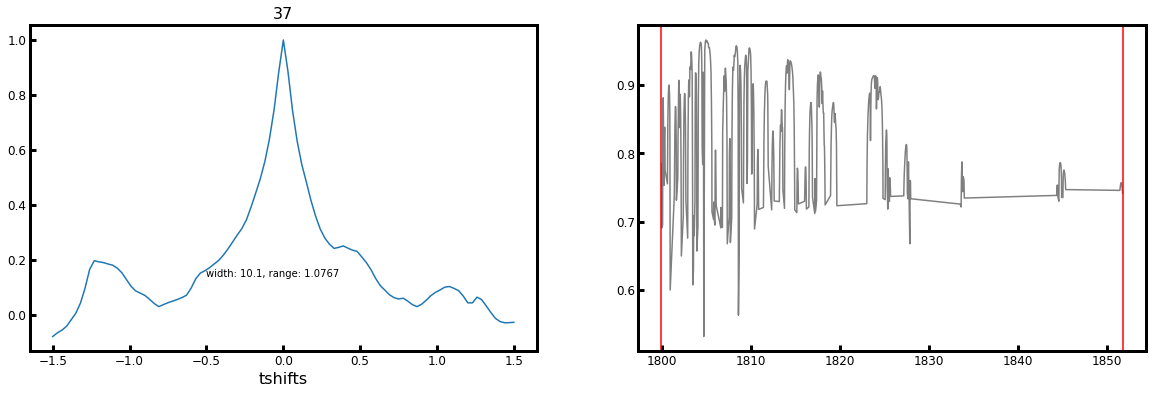

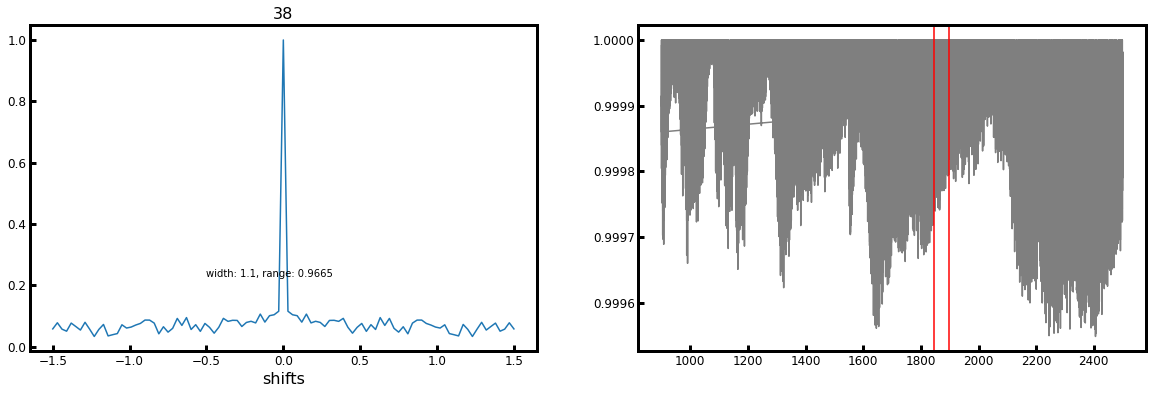

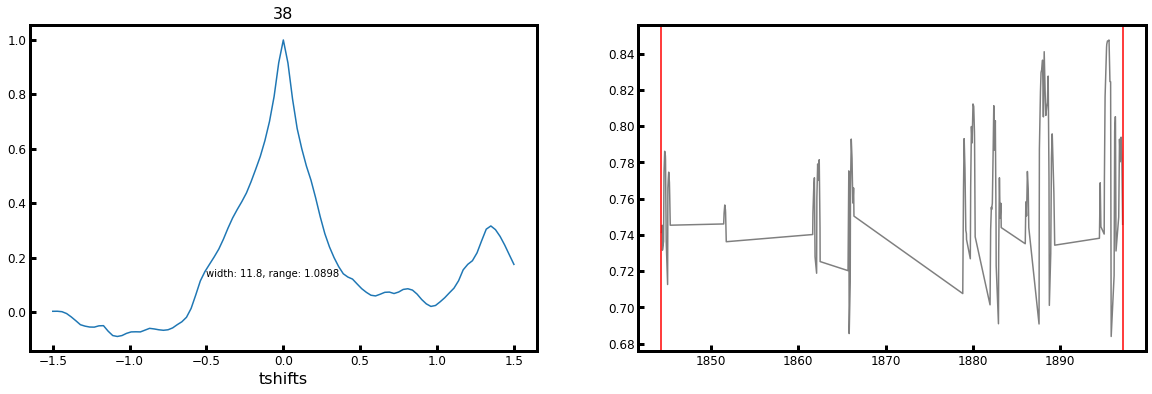

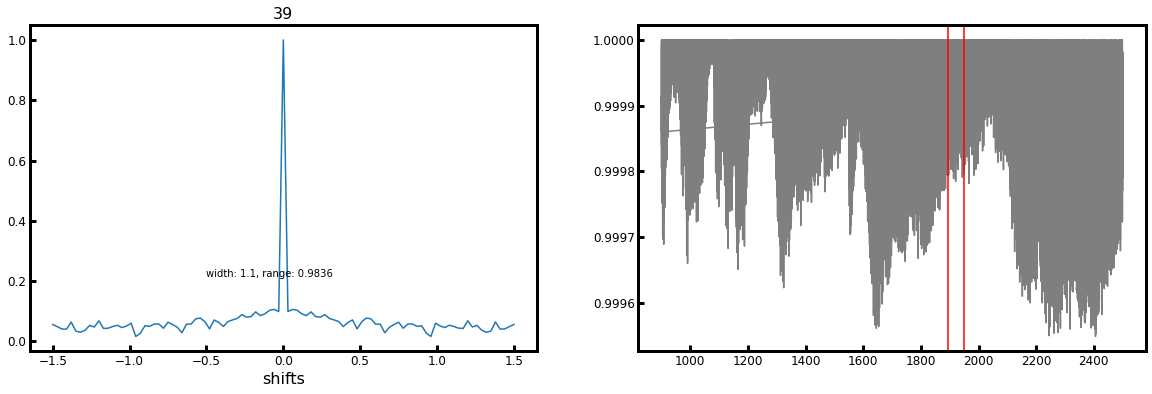

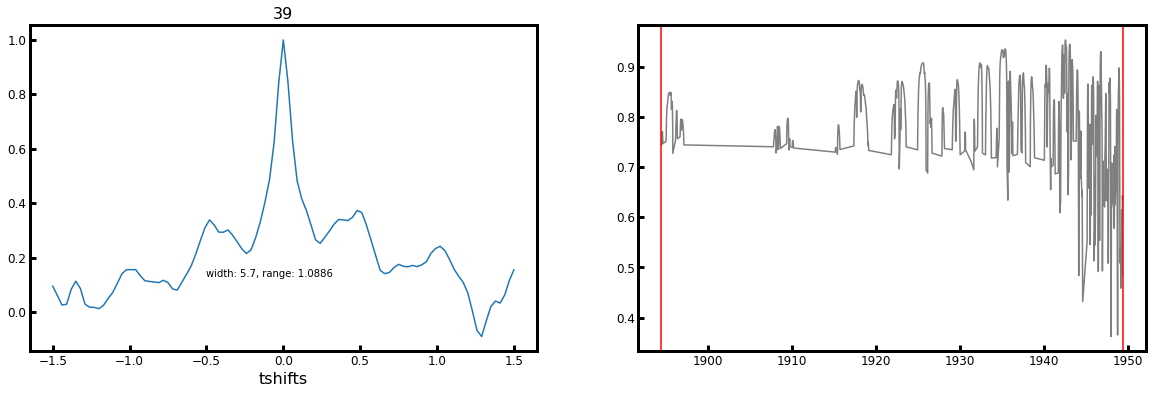

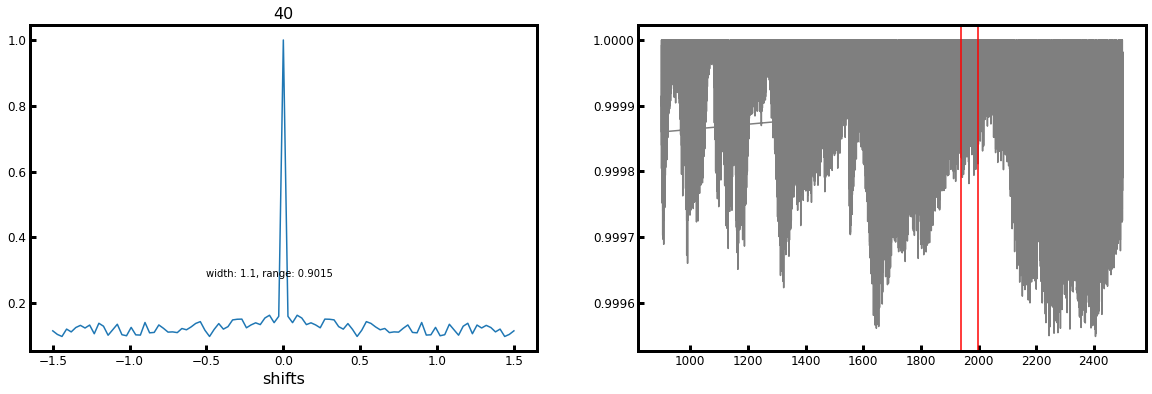

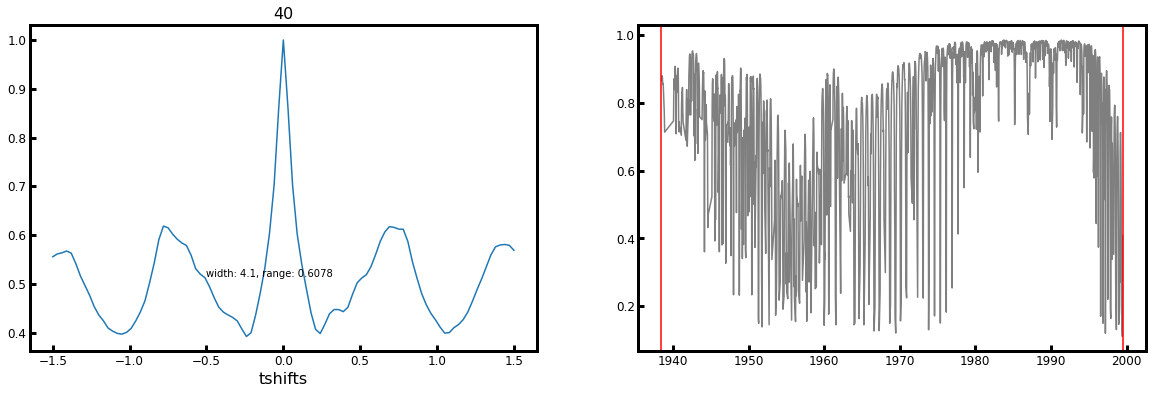

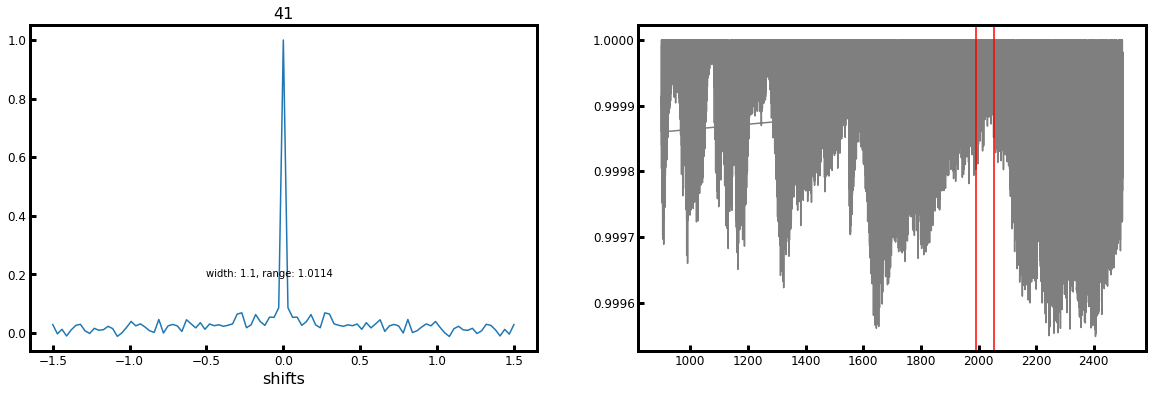

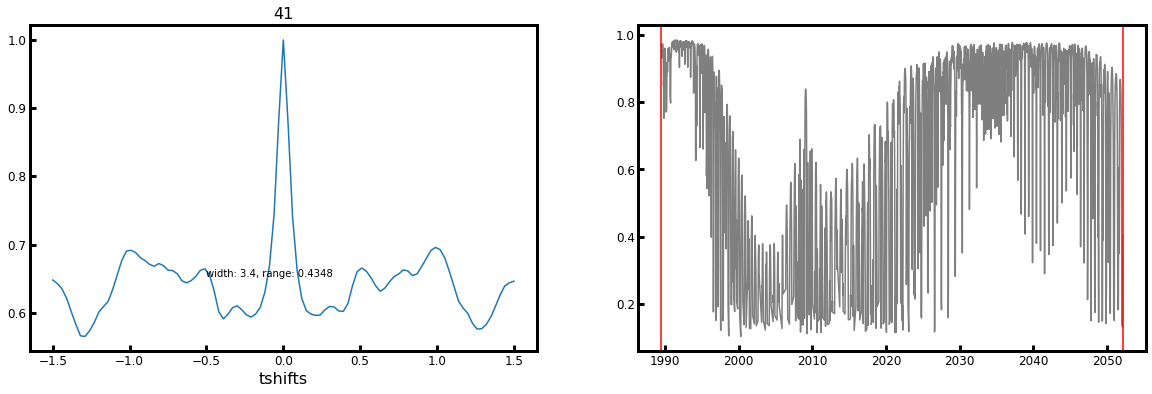

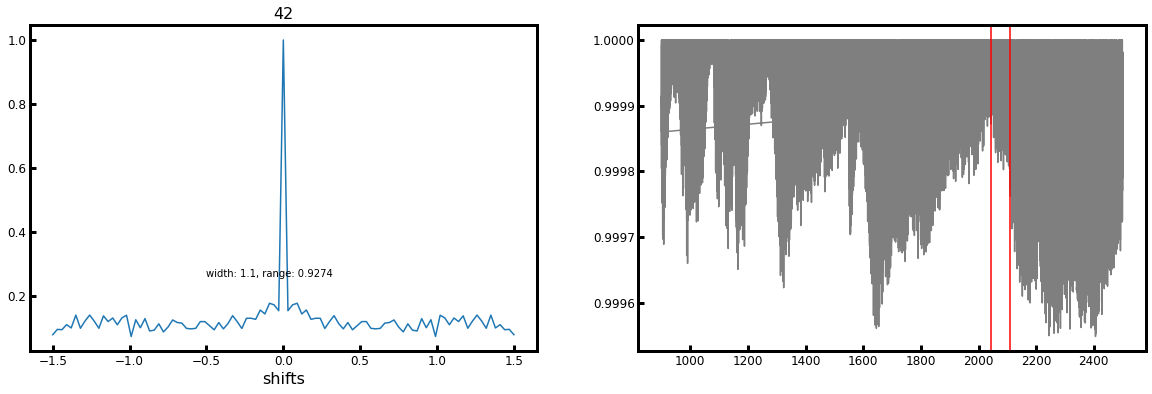

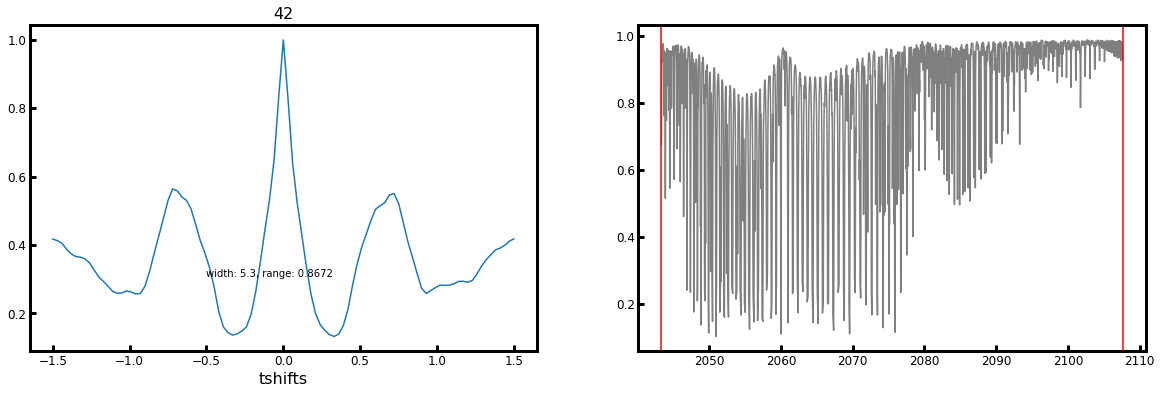

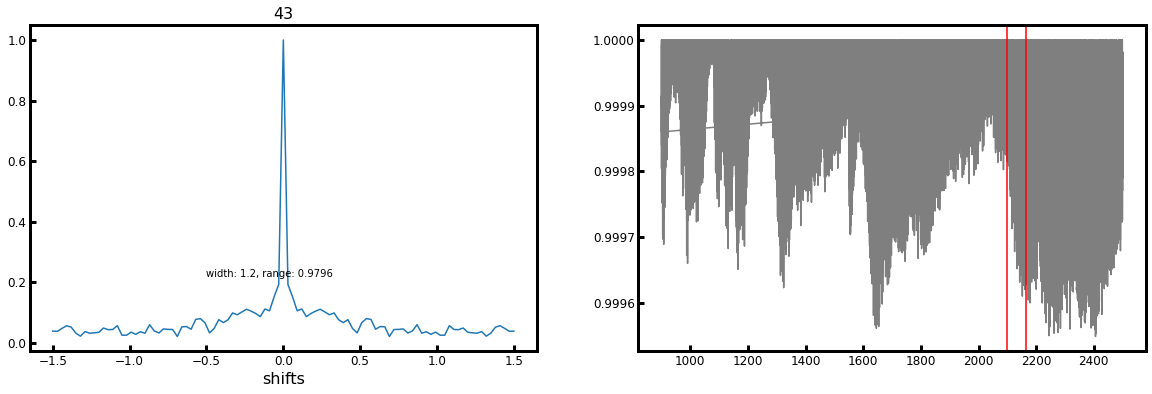

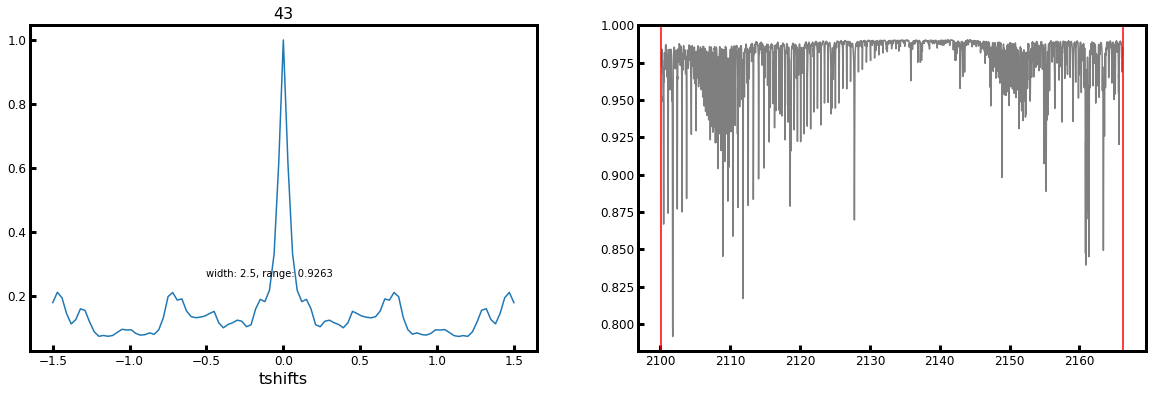

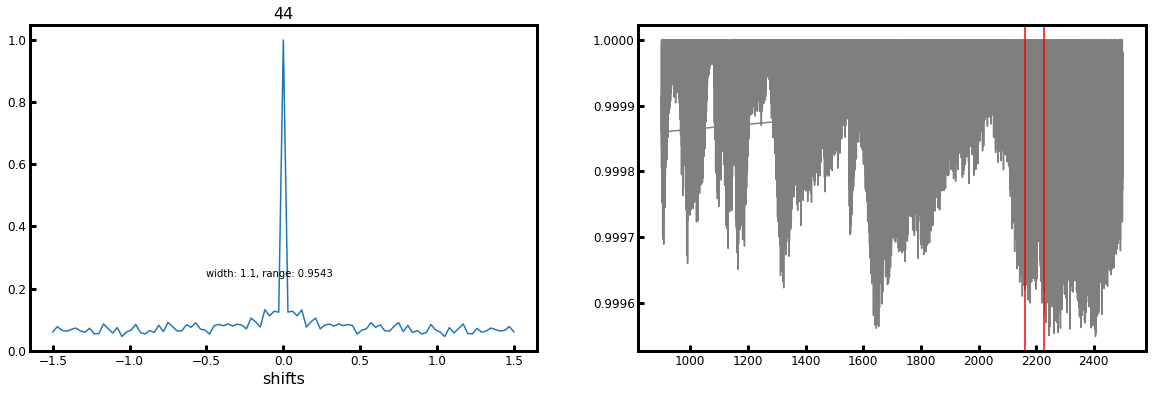

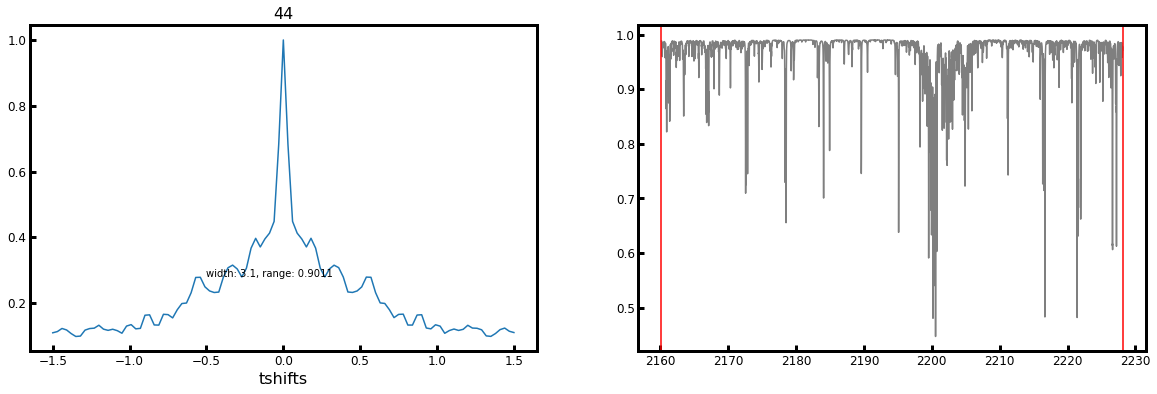

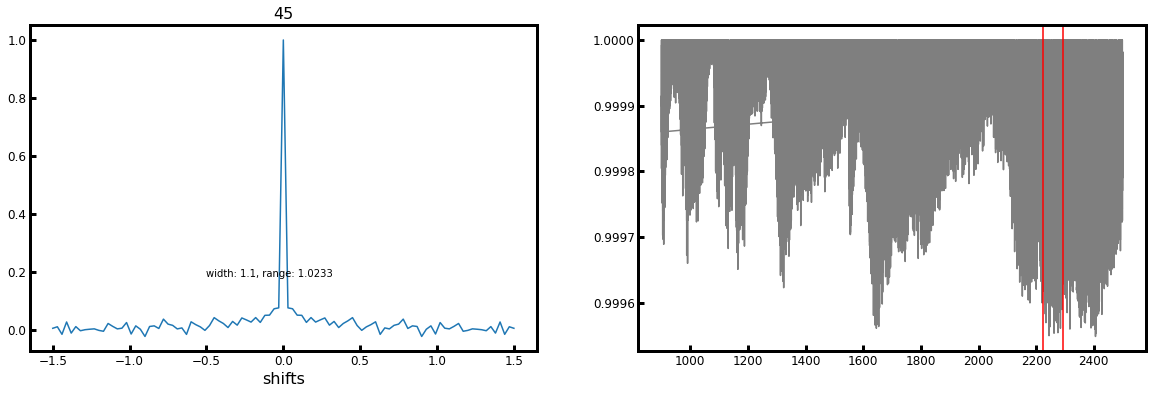

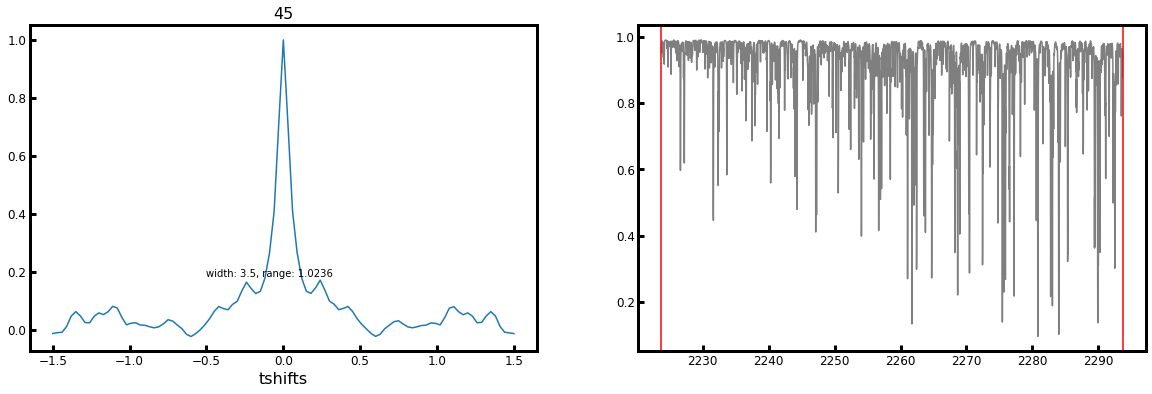

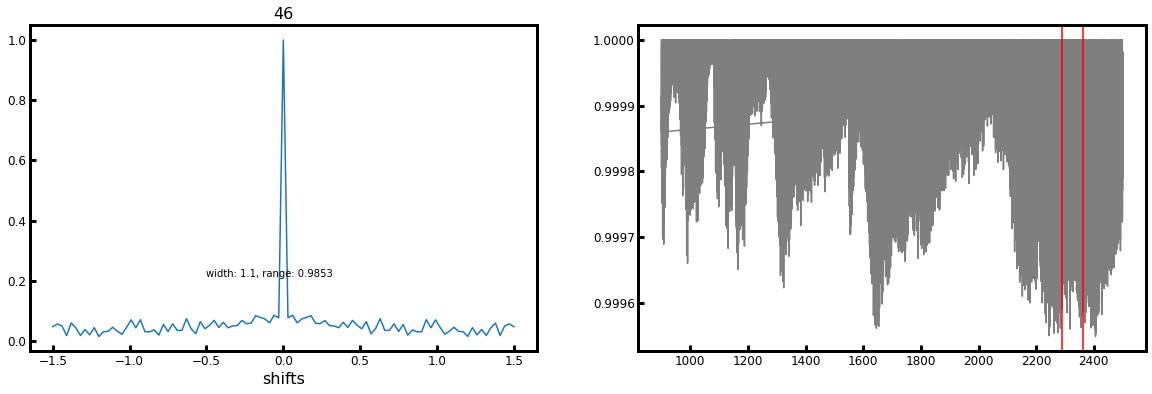

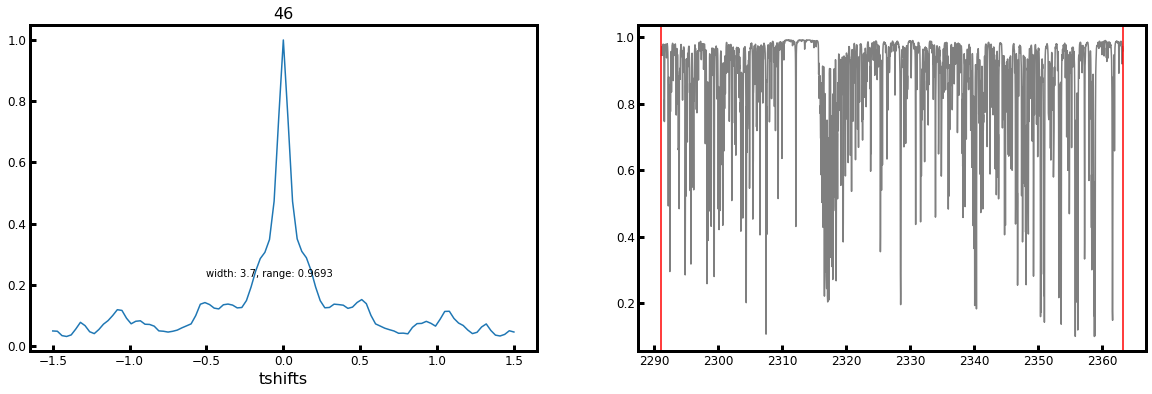

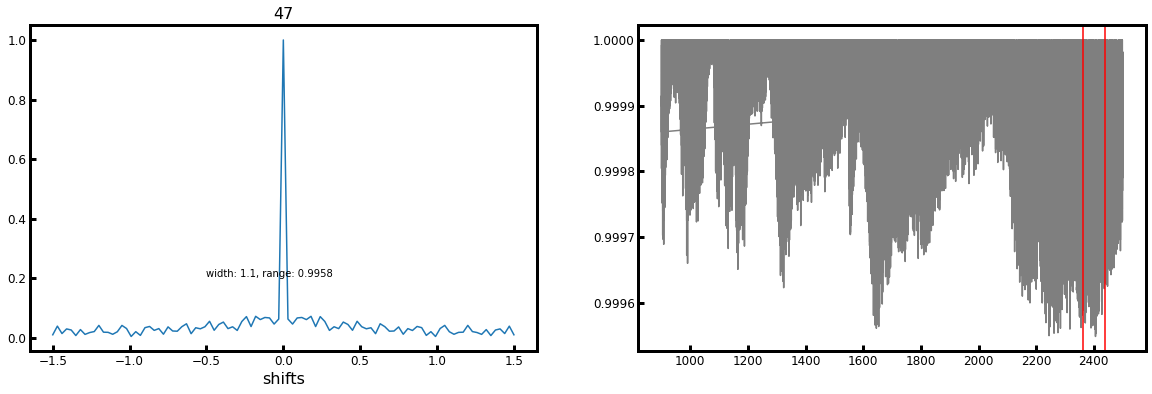

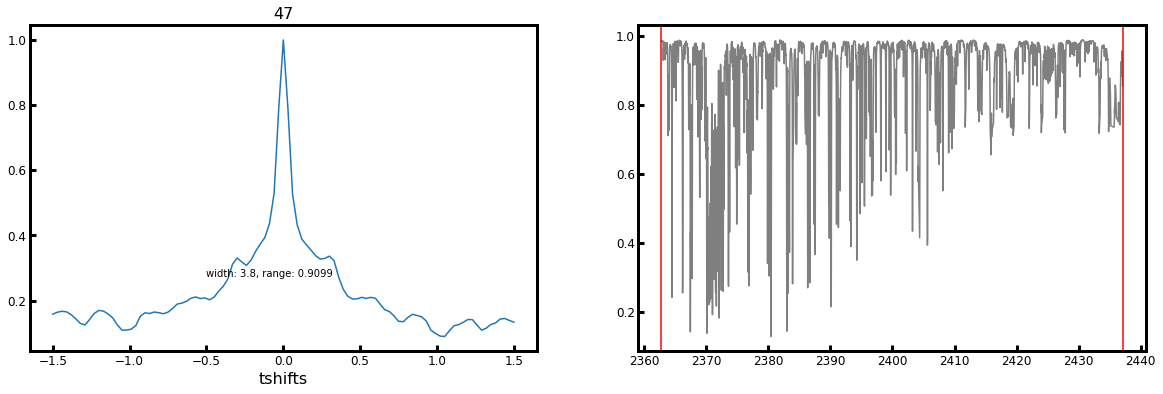

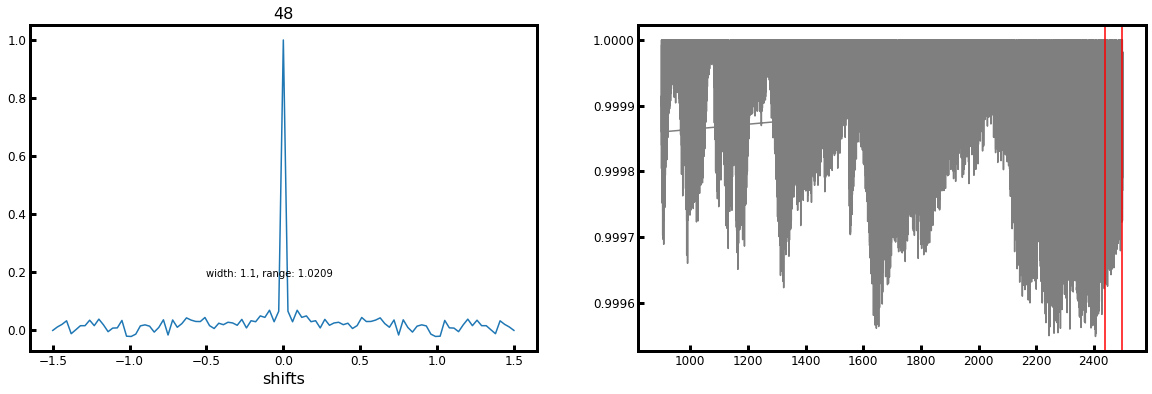

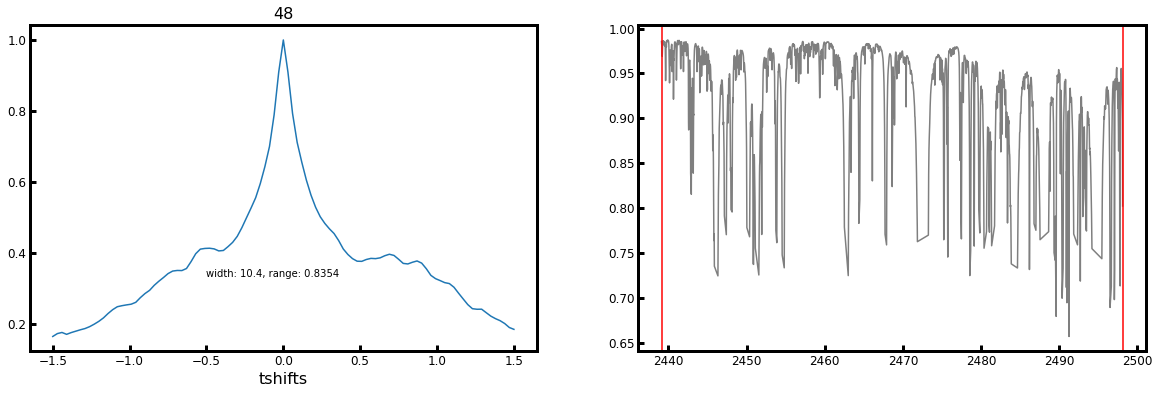

In [69]:
shifts = np.linspace(-1.5,1.5,101) # make sure to traverse 0.
tshifts = np.linspace(-1.5,1.5,101) # make sure to traverse 0.
ACF_widths = []
ACF_ranges = []
tACF_widths = []
tACF_ranges = []
for iord in range(len(WW)):
    wl = wmod_ord[iord]
    fl = fmod_ord[iord]
    twl = tell_wlens[iord]
    tfl = tell_flux[iord]
    func  = interp1d(wl,fl,bounds_error=False)
    func2 = interp1d(twl,tfl,bounds_error=False)
    _ACF = np.zeros((len(shifts)))
    _tACF = np.zeros((len(tshifts)))
    for i in range(len(shifts)):
        fl_shift = func(wl+shifts[i])
        l = np.isfinite(fl_shift)
        fl_shift = fl_shift[l]
        #ACF[i] = np.sum(np.correlate(fl,fl_shift))
        _ACF[i] = (pearsonr(fl[l],fl_shift)[0])
    for i in range(len(tshifts)):
        fl_shift = func2(twl+tshifts[i])
        l = np.isfinite(fl_shift)
        fl_shift = fl_shift[l]
        _tACF[i] = pearsonr(tfl[l],fl_shift)[0]
        
        
        
    width = peak_widths(_ACF,[50])[0][0] # 50 is the zero index
    rng   = _ACF.max()-_ACF.min()
    fig,ax = plt.subplots(1,2,figsize=(20,6))
    ax[0].plot(shifts,_ACF)
    ax[0].set_title(iord)
    ax[0].set_xlabel('shifts')
    ax[0].text(-0.5,_ACF.min()+0.2*rng,'width: {:.1f}, range: {:.4f}'.format(width,rng))
    ax[1].plot(W_mod,T_depth,'k',alpha=0.5)
    ax[1].axvline(wl.min(),color='red')
    ax[1].axvline(wl.max(),color='red')
    plt.show()
    
    ACF_widths.append(width)
    ACF_ranges.append(rng)
    #ACF.append(np.correlate(fl,fl,mode='valid')) # equiv to np.sum(fl**2) ie no shift applied
    #metric = np.sum(fl**2)
    
    width = peak_widths(_tACF,[50])[0][0] # 50 is the zero index
    rng   = _tACF.max()-_tACF.min()
    fig,ax = plt.subplots(1,2,figsize=(20,6))
    ax[0].plot(tshifts,_tACF)
    ax[0].set_title(iord)
    ax[0].set_xlabel('tshifts')
    ax[0].text(-0.5,_tACF.min()+0.2*rng,'width: {:.1f}, range: {:.4f}'.format(width,rng))
    ax[1].plot(twl,tfl,'k',alpha=0.5)
    ax[1].axvline(twl.min(),color='red')
    ax[1].axvline(twl.max(),color='red')
    plt.show()
    tACF_widths.append(width)
    tACF_ranges.append(rng)
    
    #print('Order {}: '.format(iord) + str(metric))
ACF_ranges = np.array(ACF_ranges)
ACF_widths = np.array(ACF_widths)
tACF_ranges = np.array(tACF_ranges)
tACF_widths = np.array(tACF_widths)
# normalise
ACF_widths /= ACF_widths.max()
ACF_ranges /= ACF_ranges.max()
tACF_widths /= tACF_widths.max()
tACF_ranges /= tACF_ranges.max()

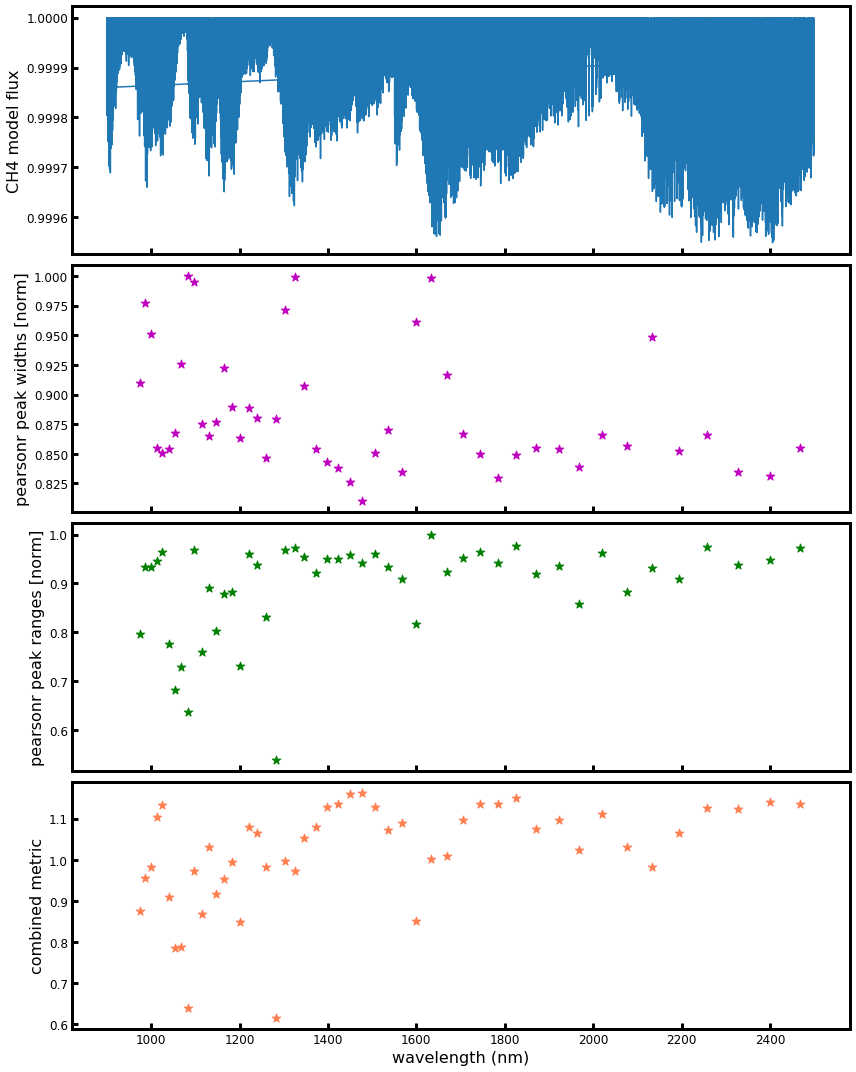

In [37]:
fig,ax = plt.subplots(4,1,sharex=True,figsize=(12,15))
fig.subplots_adjust(wspace=0, hspace=0.)
ax[0].plot(W_mod,T_depth)
#plt.axvline(wmod_ord[35][0])
#plt.axvline(wmod_ord[35][-1])
ax[1].scatter(wmod_ord_mean,ACF_widths,s=80,marker='*',color='m')
ax[1].set_ylabel('pearsonr peak widths [norm]')
ax[2].scatter(wmod_ord_mean,ACF_ranges,s=80,marker='*',color='g')
ax[2].set_ylabel('pearsonr peak ranges [norm]')

# combine metrics
ACF_comb = ACF_ranges/ACF_widths
ax[3].scatter(wmod_ord_mean,ACF_comb,s=80,marker='*',color='coral')
ax[3].set_ylabel('combined metric')

ax[0].set_ylabel('{} model flux'.format(sp))
ax[3].set_xlabel('wavelength (nm)')
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(savedir+'{}_ACF.png'.format(sp))

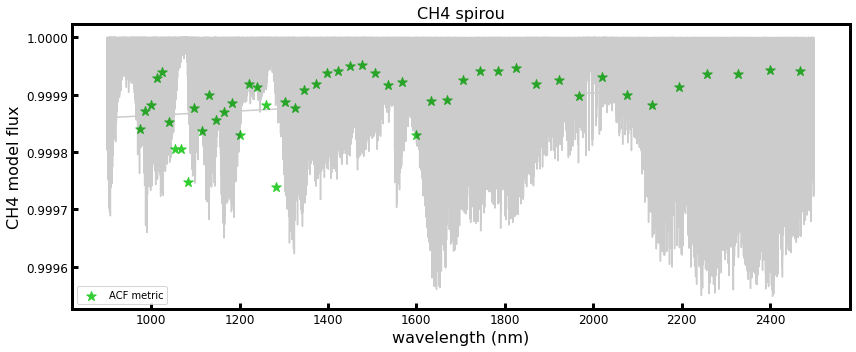

In [42]:
fig,ax = plt.subplots(figsize=(12,5))
ax.plot(W_mod,T_depth/T_depth.max(),color='k',alpha=0.2)
r = T_depth.max()-T_depth.min()
ax.scatter(wmod_ord_mean,(ACF_comb/ACF_comb.max())*r+0.9995,s=100,marker='*',color='limegreen',label='ACF metric')

plt.ylabel('{} model flux'.format(sp))
plt.xlabel('wavelength (nm)')
plt.title('{} {}'.format(sp,instrument))
plt.tight_layout()
plt.legend()
fig.patch.set_facecolor('white')
plt.savefig(savedir+'{}_ACF_{}.png'.format(sp,instrument))

# save combined metric as normalised 'weightings'
np.save(savedir+'{}_ACF_{}_metric.npy'.format(sp,instrument),ACF_comb/ACF_comb.max())

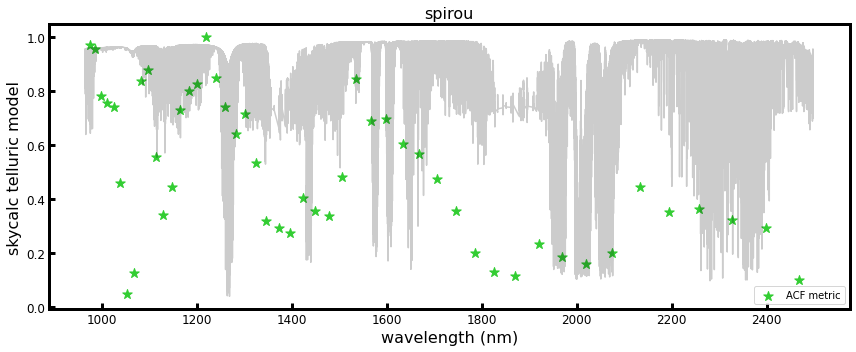

In [83]:
# tellurics
tACF_comb = tACF_ranges/tACF_widths # max => higher ACF, so want to minimise this for tellurics
fig,ax = plt.subplots(figsize=(12,5))
twl = [item for sublist in tell_wlens for item in sublist]
tfl = [item for sublist in tell_flux for item in sublist]
twl = np.array(twl)
ip  = np.argsort(twl)
twl = twl[ip]
tfl = np.array(tfl)
tfl = tfl[ip]

ax.plot(twl,tfl,color='k',alpha=0.2)
#r = T_depth.max()-T_depth.min()
ax.scatter(wmod_ord_mean,tACF_comb/tACF_comb.max(),s=100,marker='*',color='limegreen',label='ACF metric')

plt.ylabel('skycalc telluric model')
plt.xlabel('wavelength (nm)')
plt.title('{}'.format(instrument))
plt.tight_layout()
plt.legend()
fig.patch.set_facecolor('white')
#plt.savefig(savedir+'{}_ACF_{}.png'.format(sp,instrument))